In [1]:
import csv
from typing import Text
from yaml import tokens
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST, EMNIST

from helper import Helper
import random
from utils.text_load import Dictionary
from models.word_model import RNNModel
from models.resnet_cifar100 import ResNet18
from models.resnet_cifar100 import ResNet34
from models.lenet import LeNet
from models.edge_case_cnn import Net
from models.resnet9 import ResNet9
from utils.text_load import *
import numpy as np
import copy
from torch.utils.data import Dataset, DataLoader

import os
from torchvision import datasets, transforms
from collections import defaultdict
from torch.utils.data import DataLoader, random_split, TensorDataset
import pickle
from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam
import PIL
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import io


def superimpose(background, overlay):
    # added_image = background
    added_image = cv.addWeighted(background,0.3,overlay,0.3,-133)
    return (added_image.reshape(32,32,3))

label_dict = {
    0:'plane',
    1:'car',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
}

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

d:\Anaconda3\envs\xwdneurotoxin\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# no attack model 的模型下 对于每个数据的预测结果的熵的分布
params = torch.load("D:\code\code_xwd\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\cifar100_no_posion_saved_model\(ResNet34,放开FC反向学习,TOP5)saved_models_update1_noniid_0.9_cifar100_EC0_EE3000/cifar100_resnet_Snorm_1_checkpoint_model_epoch_900.pth")


file_benign = 'F:\datasets\cifar100\cifar-100-python/test'
file_attack = 'F:\datasets\cifar100\patch_cifar100/test'
file_attack_poison = 'F:\datasets\cifar100\poison_cifar100/test'
file_attack_DBA = 'F:\datasets\cifar100\DBA_cifar100/test'

dict = unpickle(file_benign)
model = ResNet34(num_classes=100)
model.cuda()

model.load_state_dict(params,False)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2,
                                                momentum=0.09,
                                                weight_decay=0.4)

fo = open(file_benign, 'rb')
label = pickle.load(fo, encoding='latin1')
fo.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_benign = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        num_random = random.randint(1,3333)
        image_trigger = np.reshape(dict.get("data")[i+num_random], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]

        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_benign[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_benign[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_benign)
        sum = sum + EntropySum_benign[k * 10 + i]
print(sum/100/10)
# print(EntropySum_benign)

# 100张 benign + 10次混合其他图片 在poison下信息熵均值为 -0.8485037518674508
# 100张 poison + 10次混合其他图片 在poison下信息熵均值为 -0.7518131062481552

# 100张 benign + 10次混合其他图片 在patch下信息熵均值为 8.130794444084168
# 100张 patch + 10次混合其他图片 在patch下信息熵均值为 7.389559324502945
dict = unpickle(file_attack)
f1 = open(file_attack, 'rb')
label = pickle.load(f1, encoding='latin1')
f1.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack)
        sum = sum + EntropySum_attack[k * 10 + i]
print(sum/100/10)

dict = unpickle(file_attack_poison)
f2 = open(file_attack_poison, 'rb')
label = pickle.load(f2, encoding='latin1')
f2.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack_poison = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack_poison[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack_poison[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack_poison)
        sum = sum + EntropySum_attack_poison[k * 10 + i]
print(sum/100/10)

dict = unpickle(file_attack_DBA)
f2 = open(file_attack_DBA, 'rb')
label = pickle.load(f2, encoding='latin1')
f2.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack_DBA = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        num_random = random.randint(1,3333)
        image_trigger = np.reshape(dict.get("data")[i+num_random], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack_DBA[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack_DBA[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack_DBA)
        sum = sum + EntropySum_attack_DBA[k * 10 + i]
print(sum/100/10)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1664\1226311140.py:57: RuntimeWarning: invalid value encountered in log2
  EntropySum_benign[k * 10 + i] = -np.nansum(output*np.log2(output))


16.536073422431947


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1664\1226311140.py:105: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack[k * 10 + i] = -np.nansum(output*np.log2(output))


16.374868206024168


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1664\1226311140.py:147: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack_poison[k * 10 + i] = -np.nansum(output*np.log2(output))


16.279897372245788


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1664\1226311140.py:190: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack_DBA[k * 10 + i] = -np.nansum(output*np.log2(output))


17.287607383728027


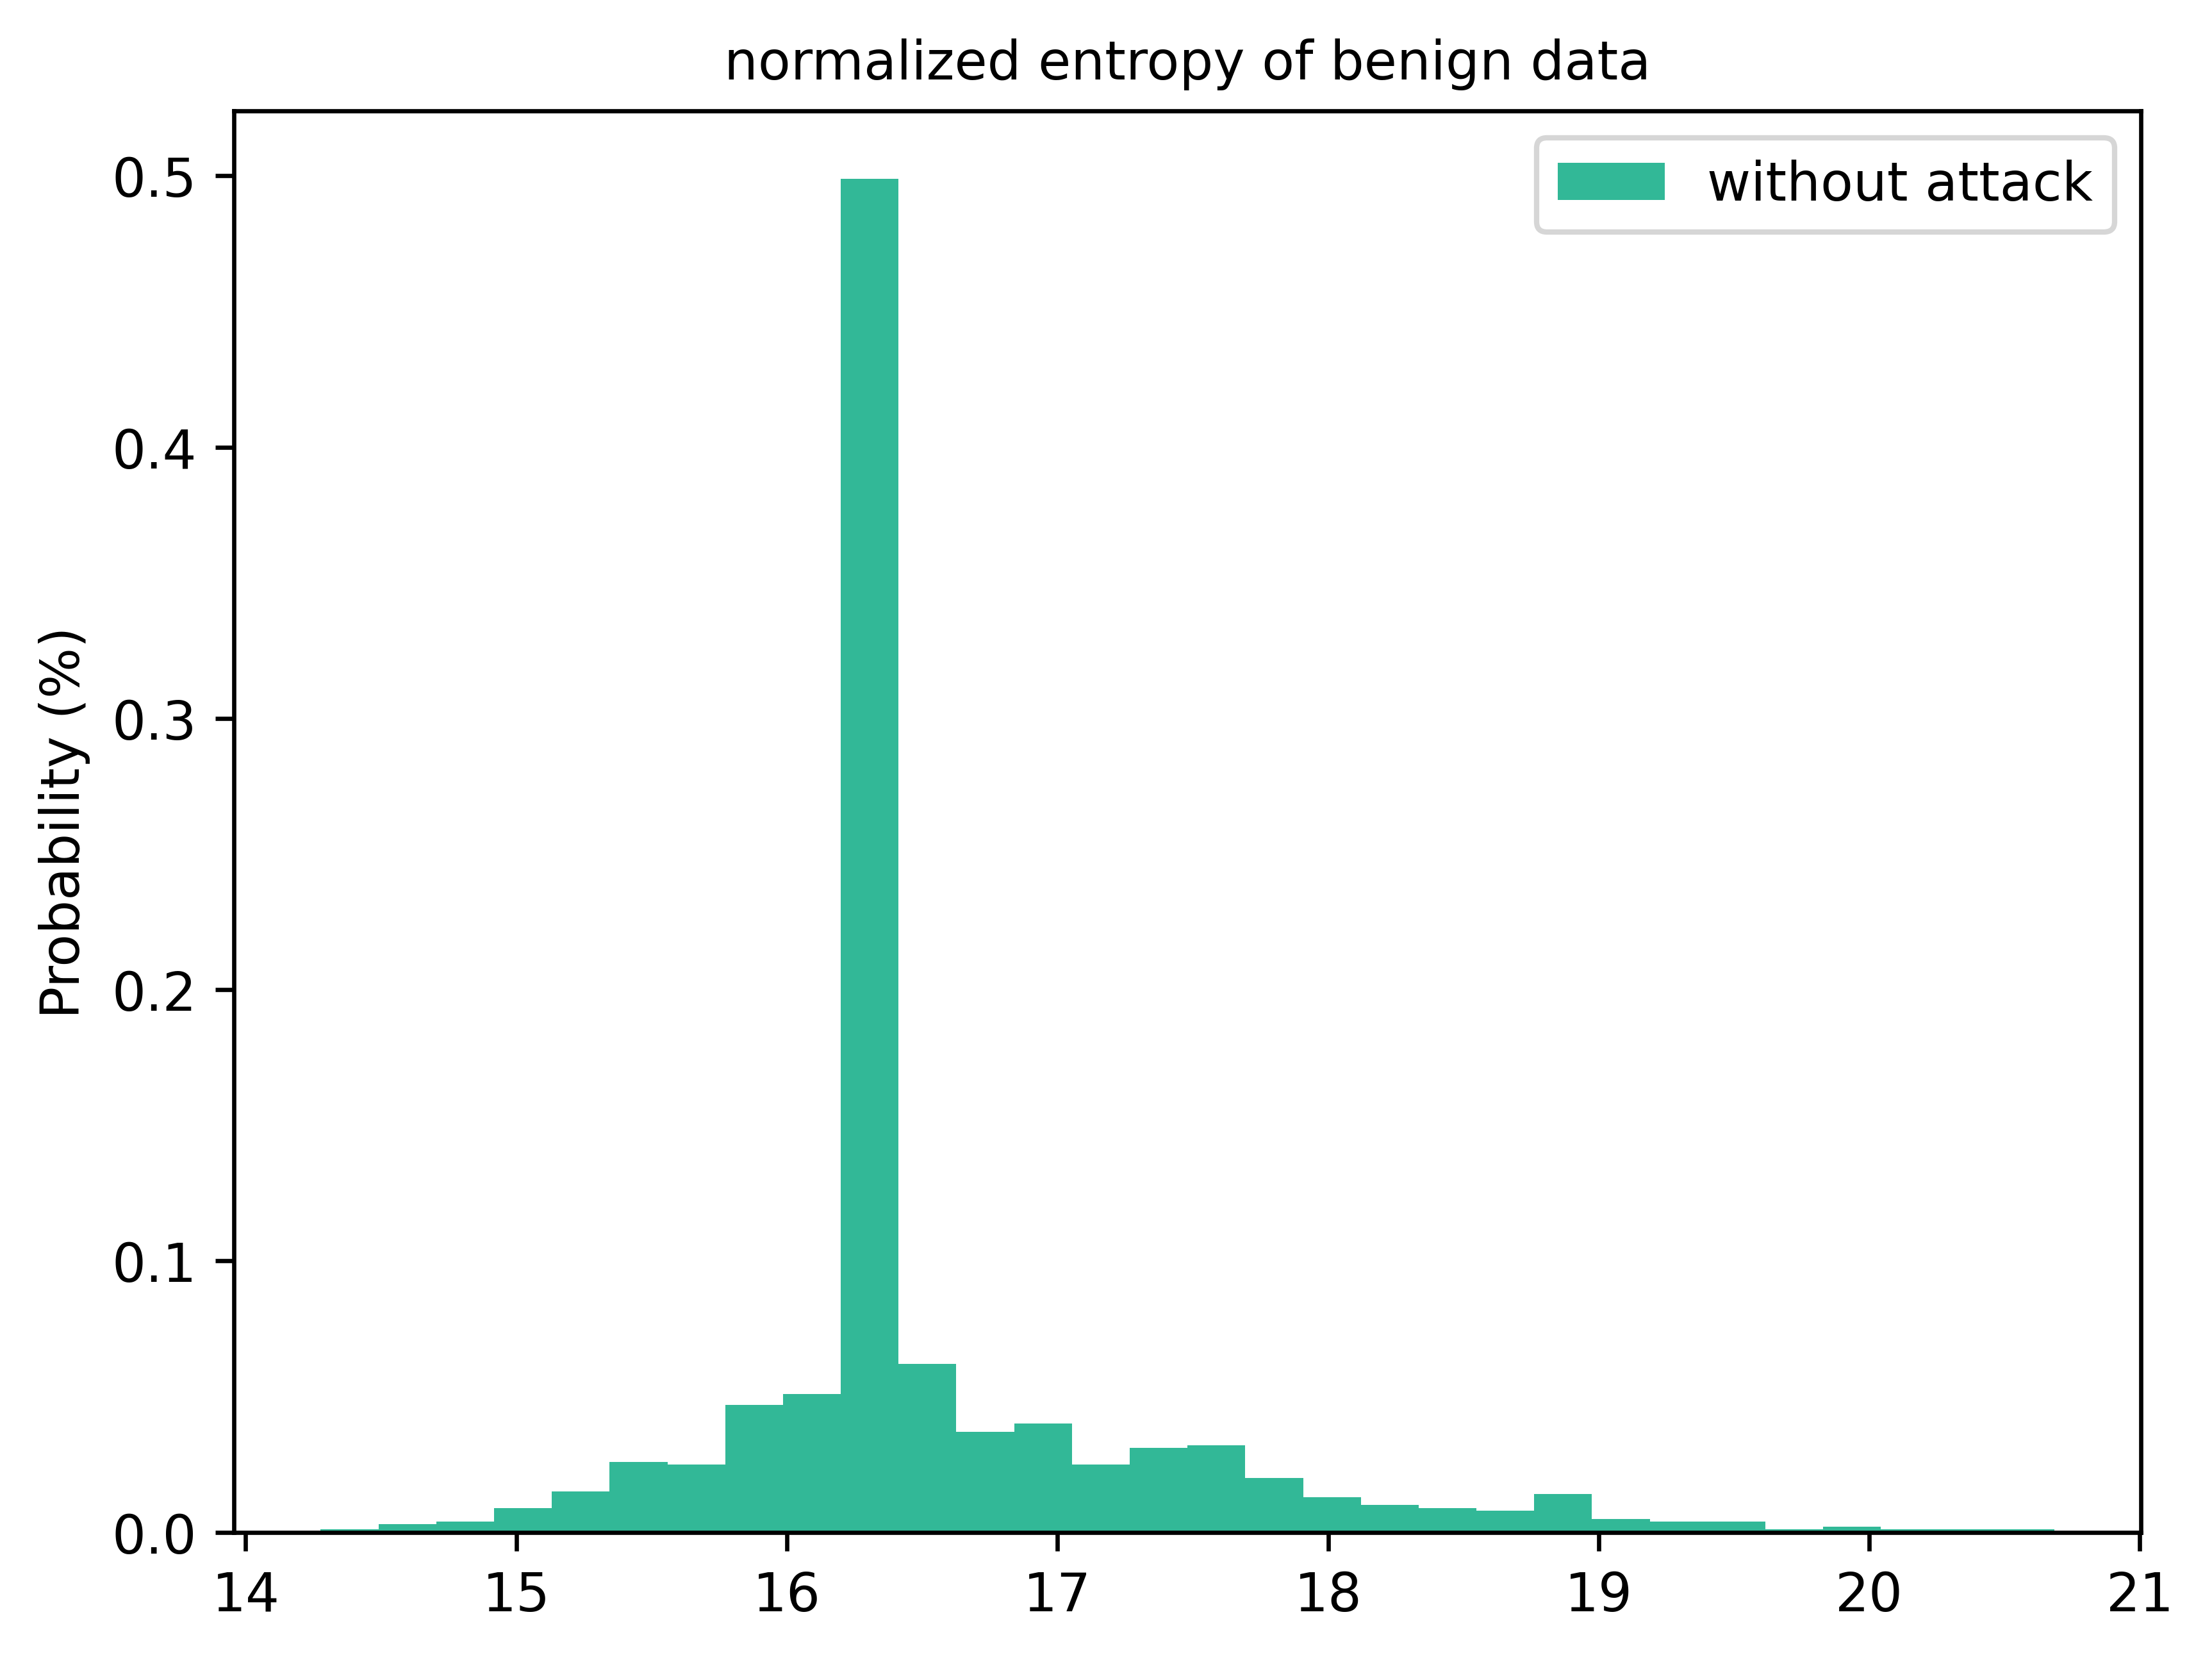

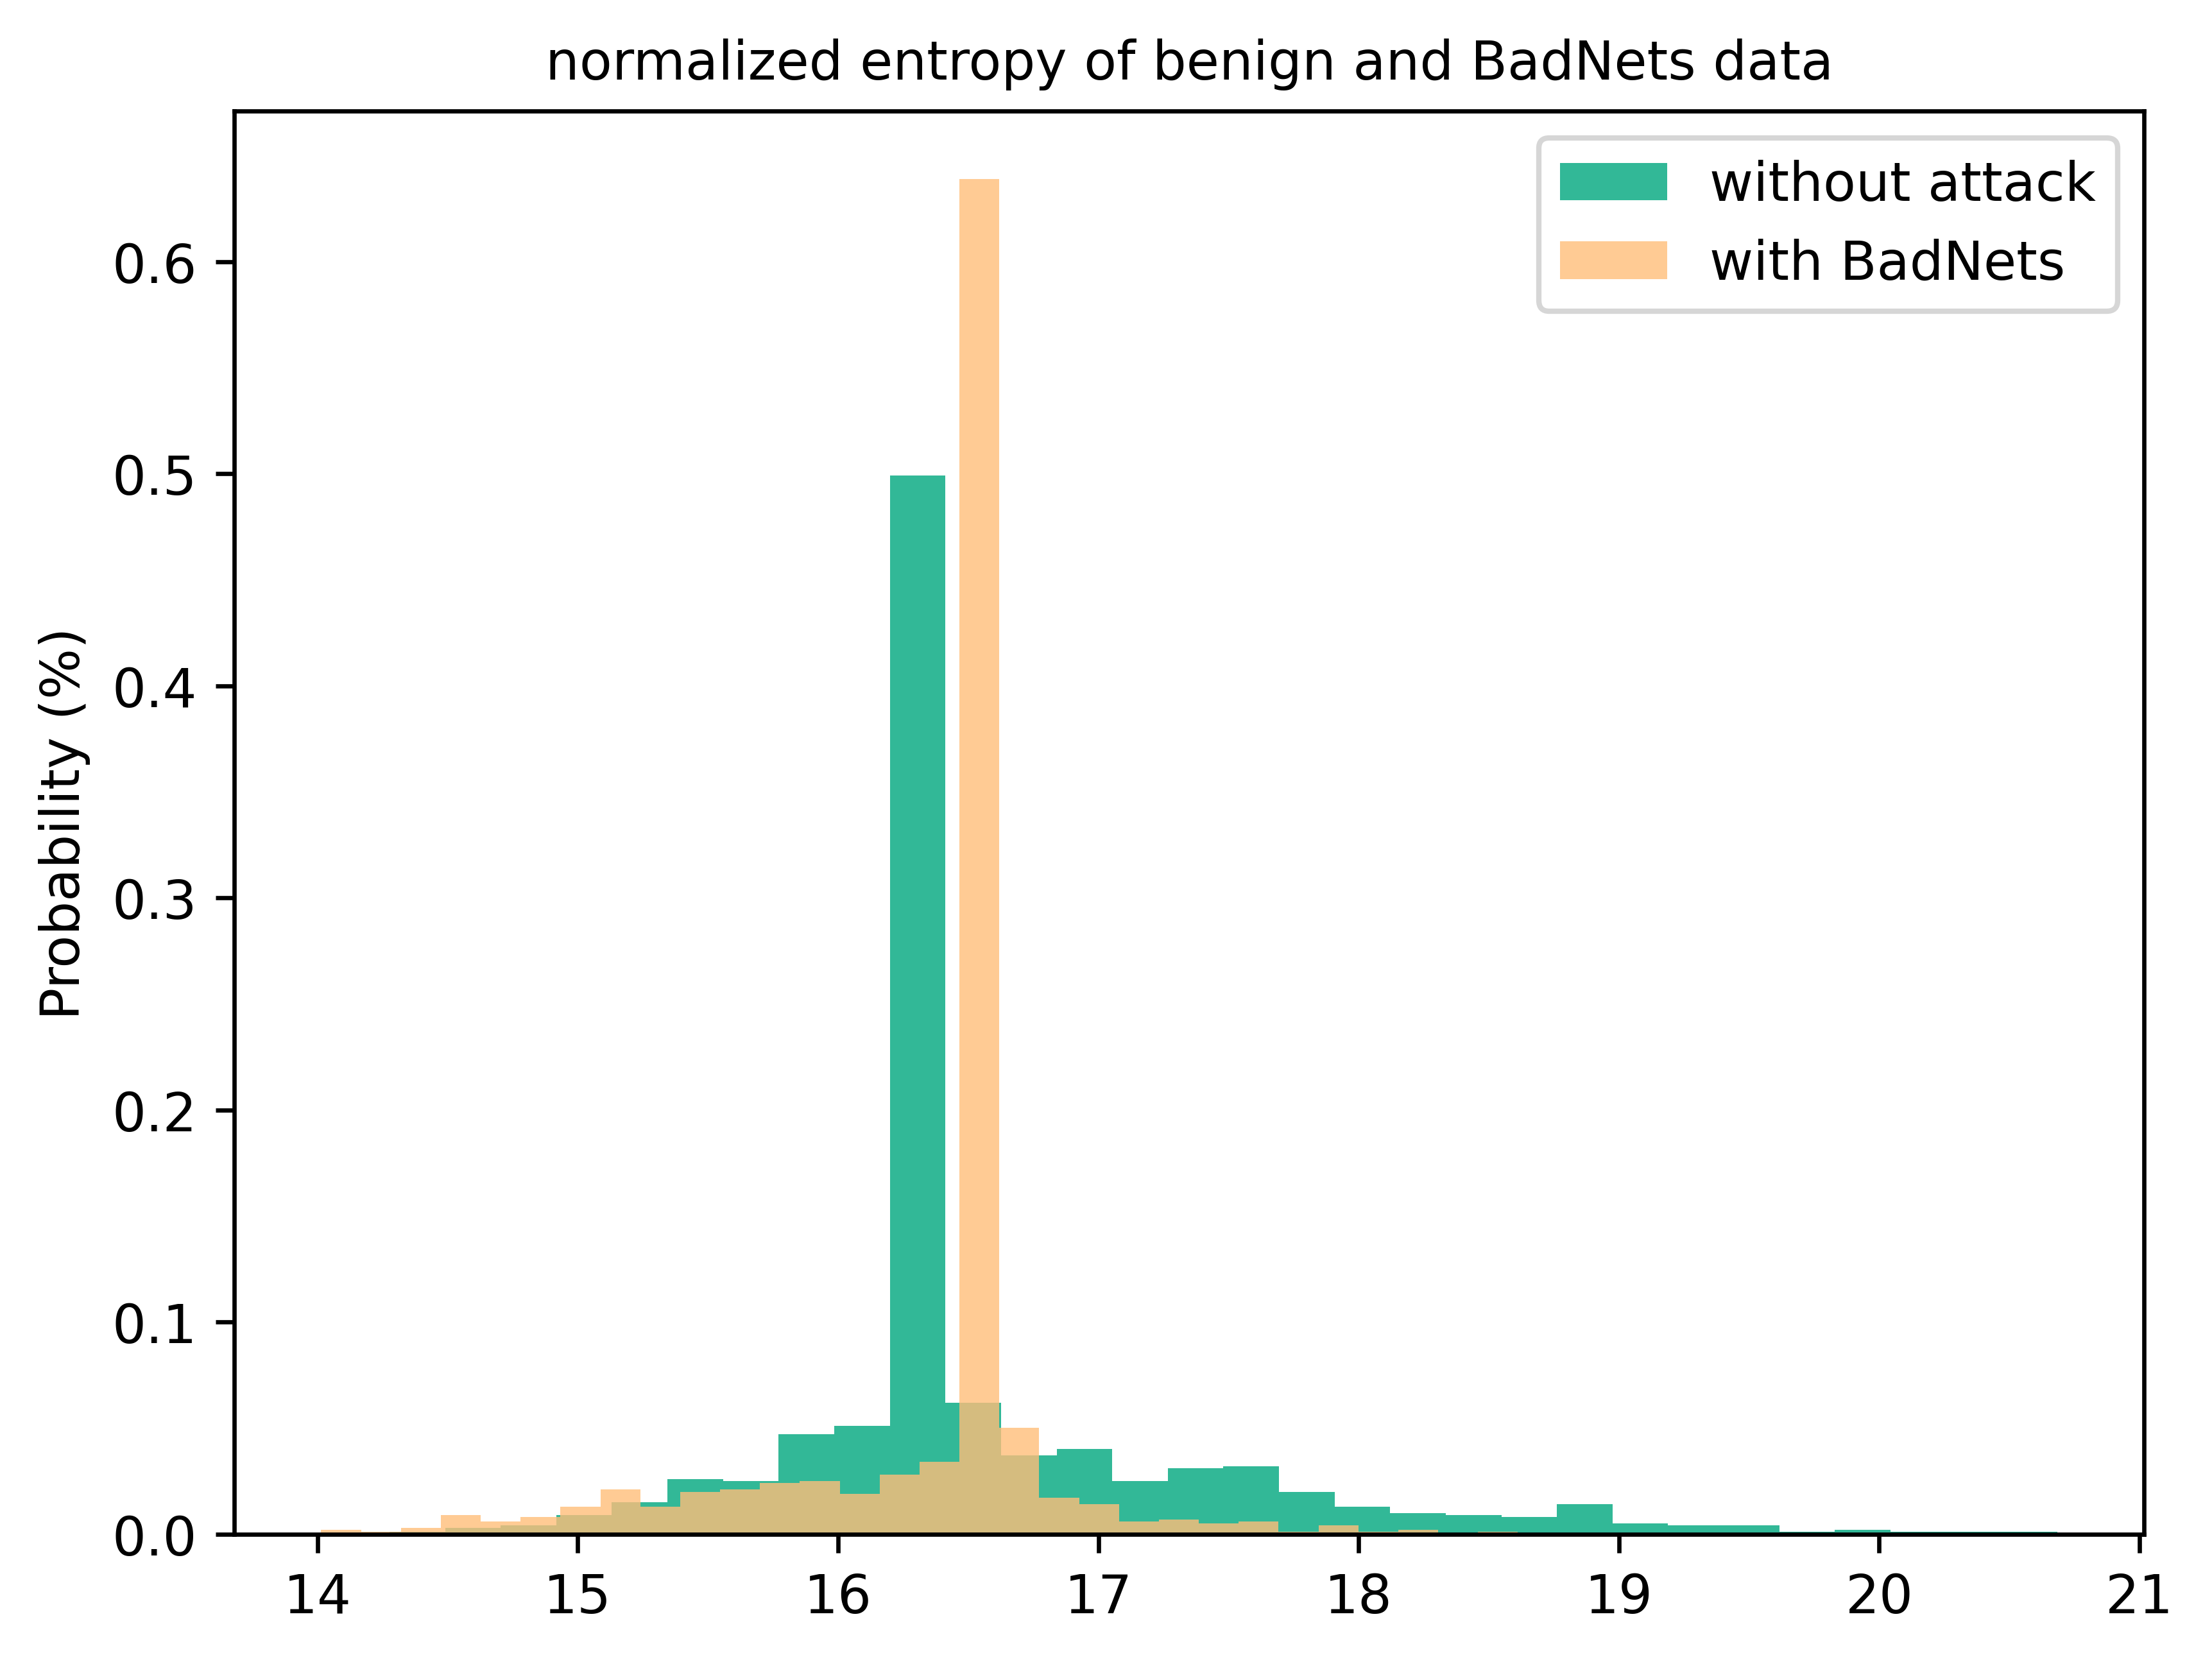

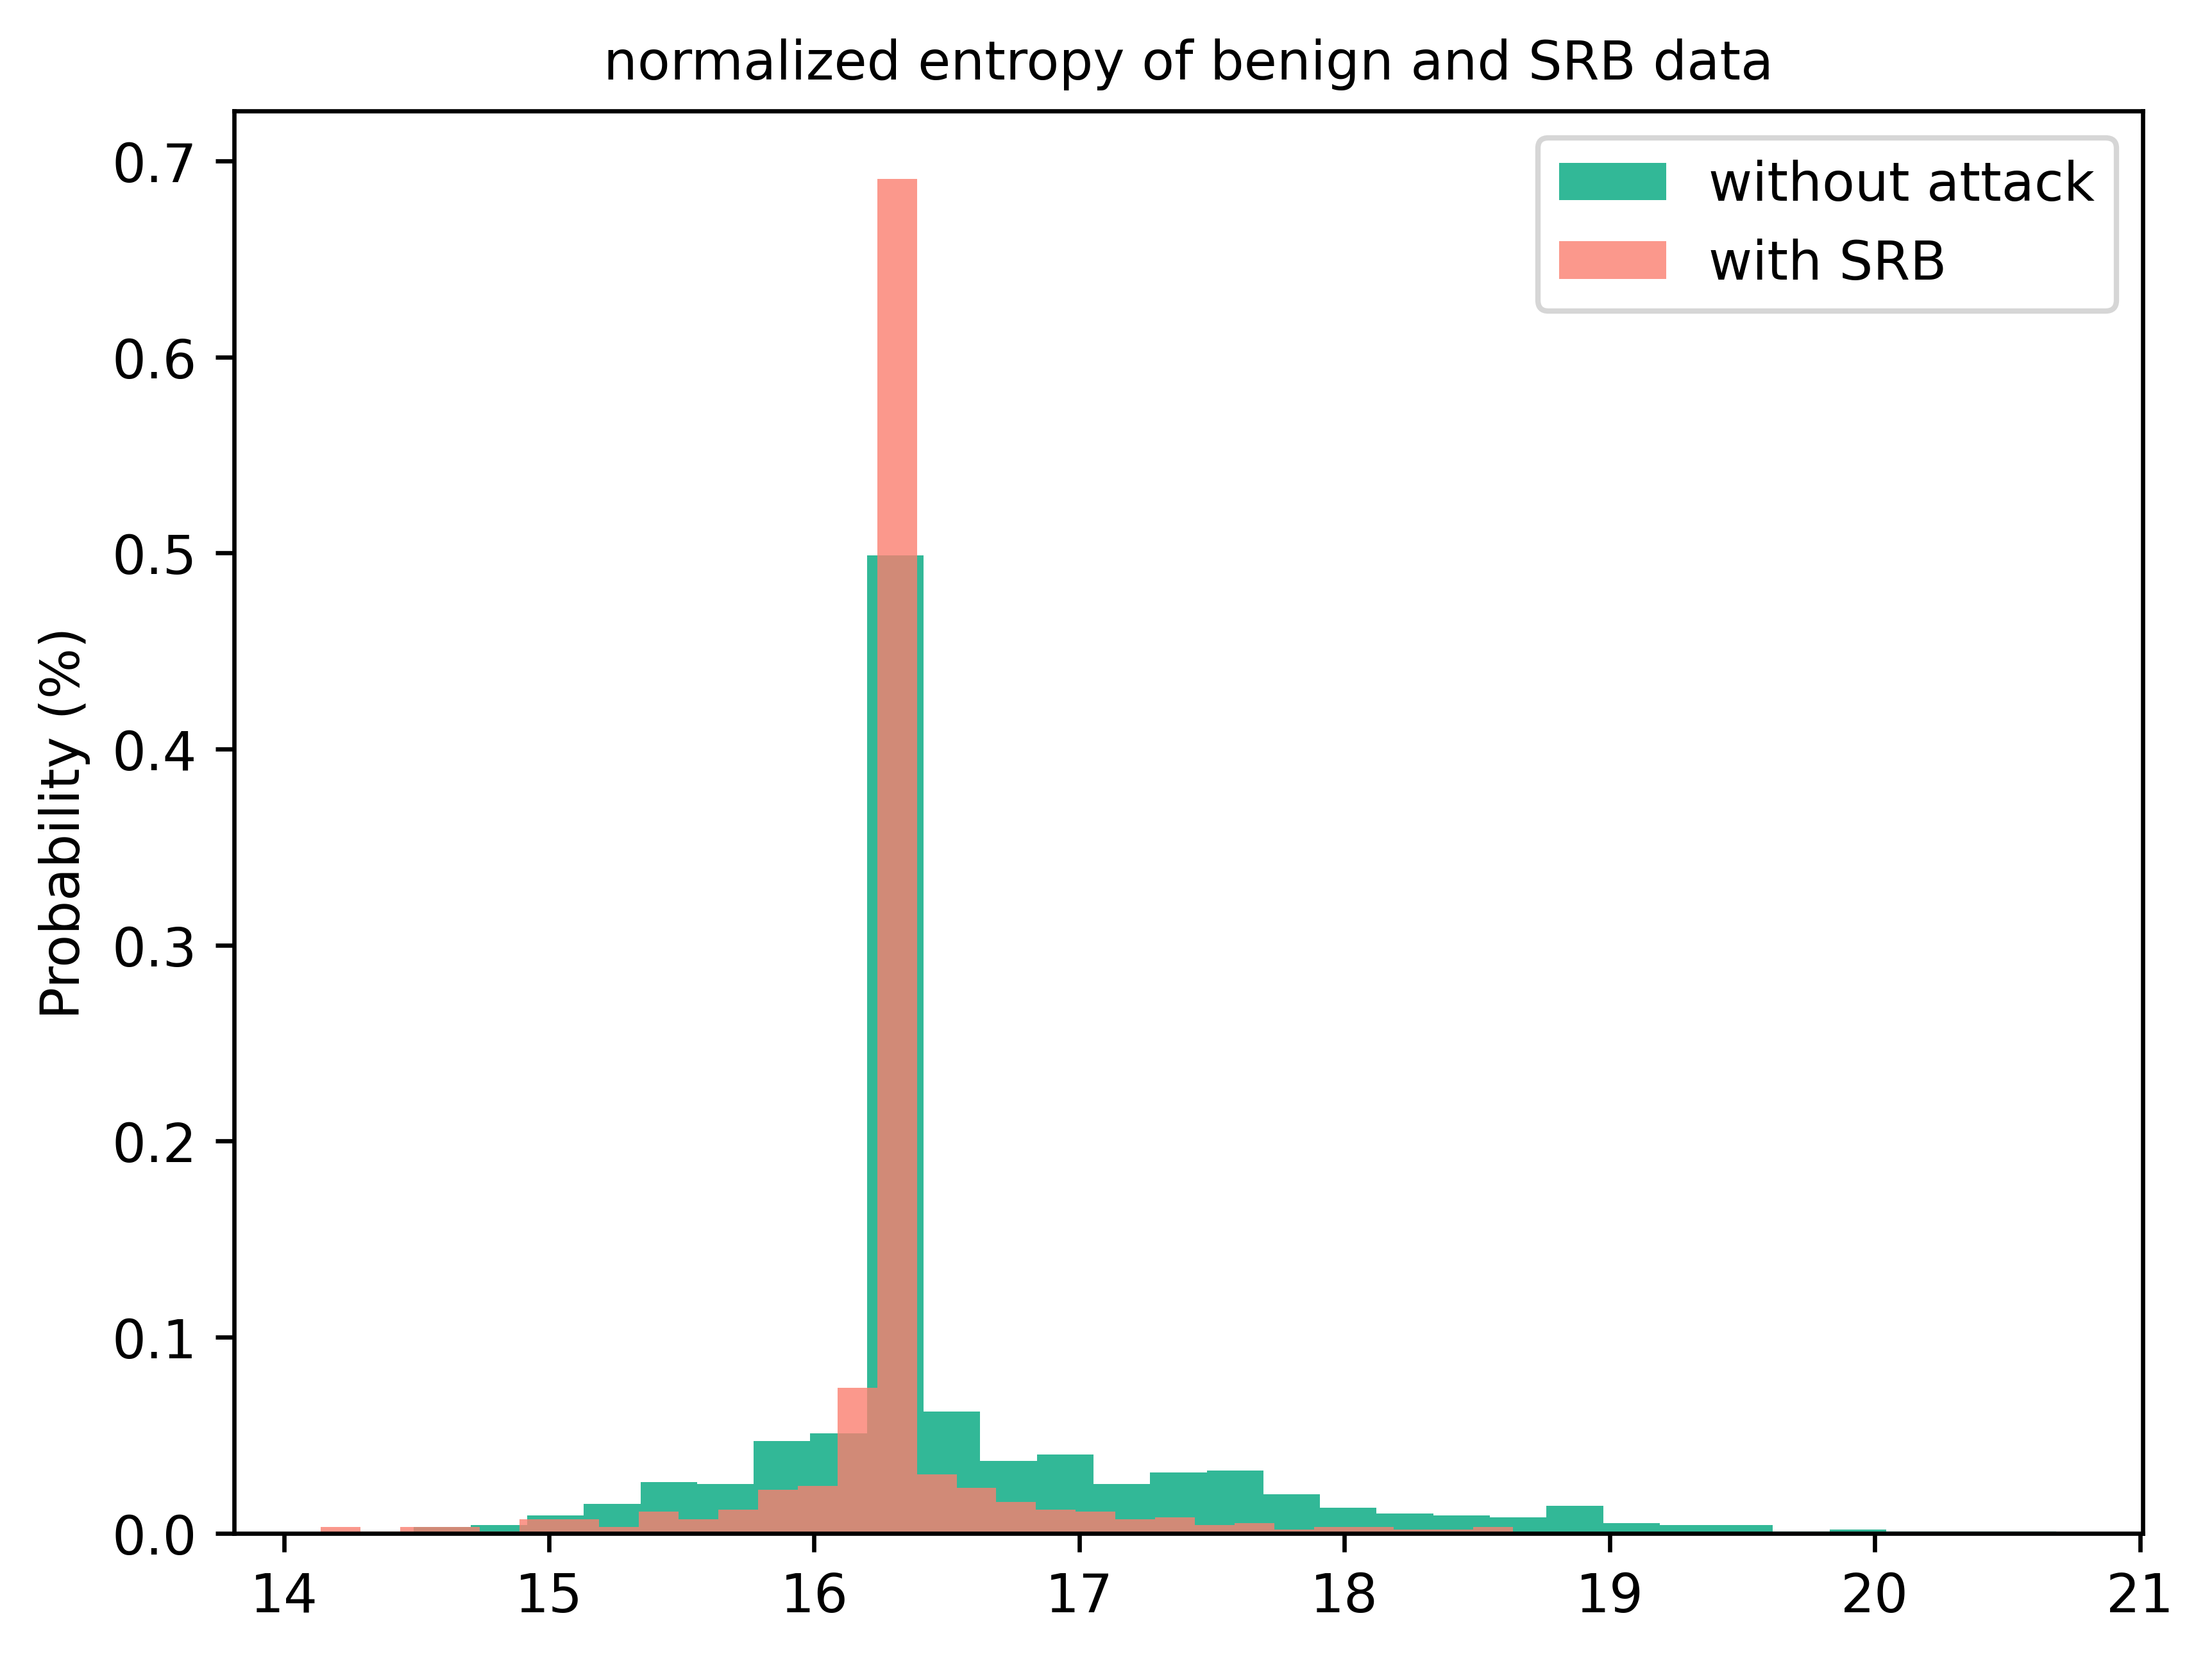

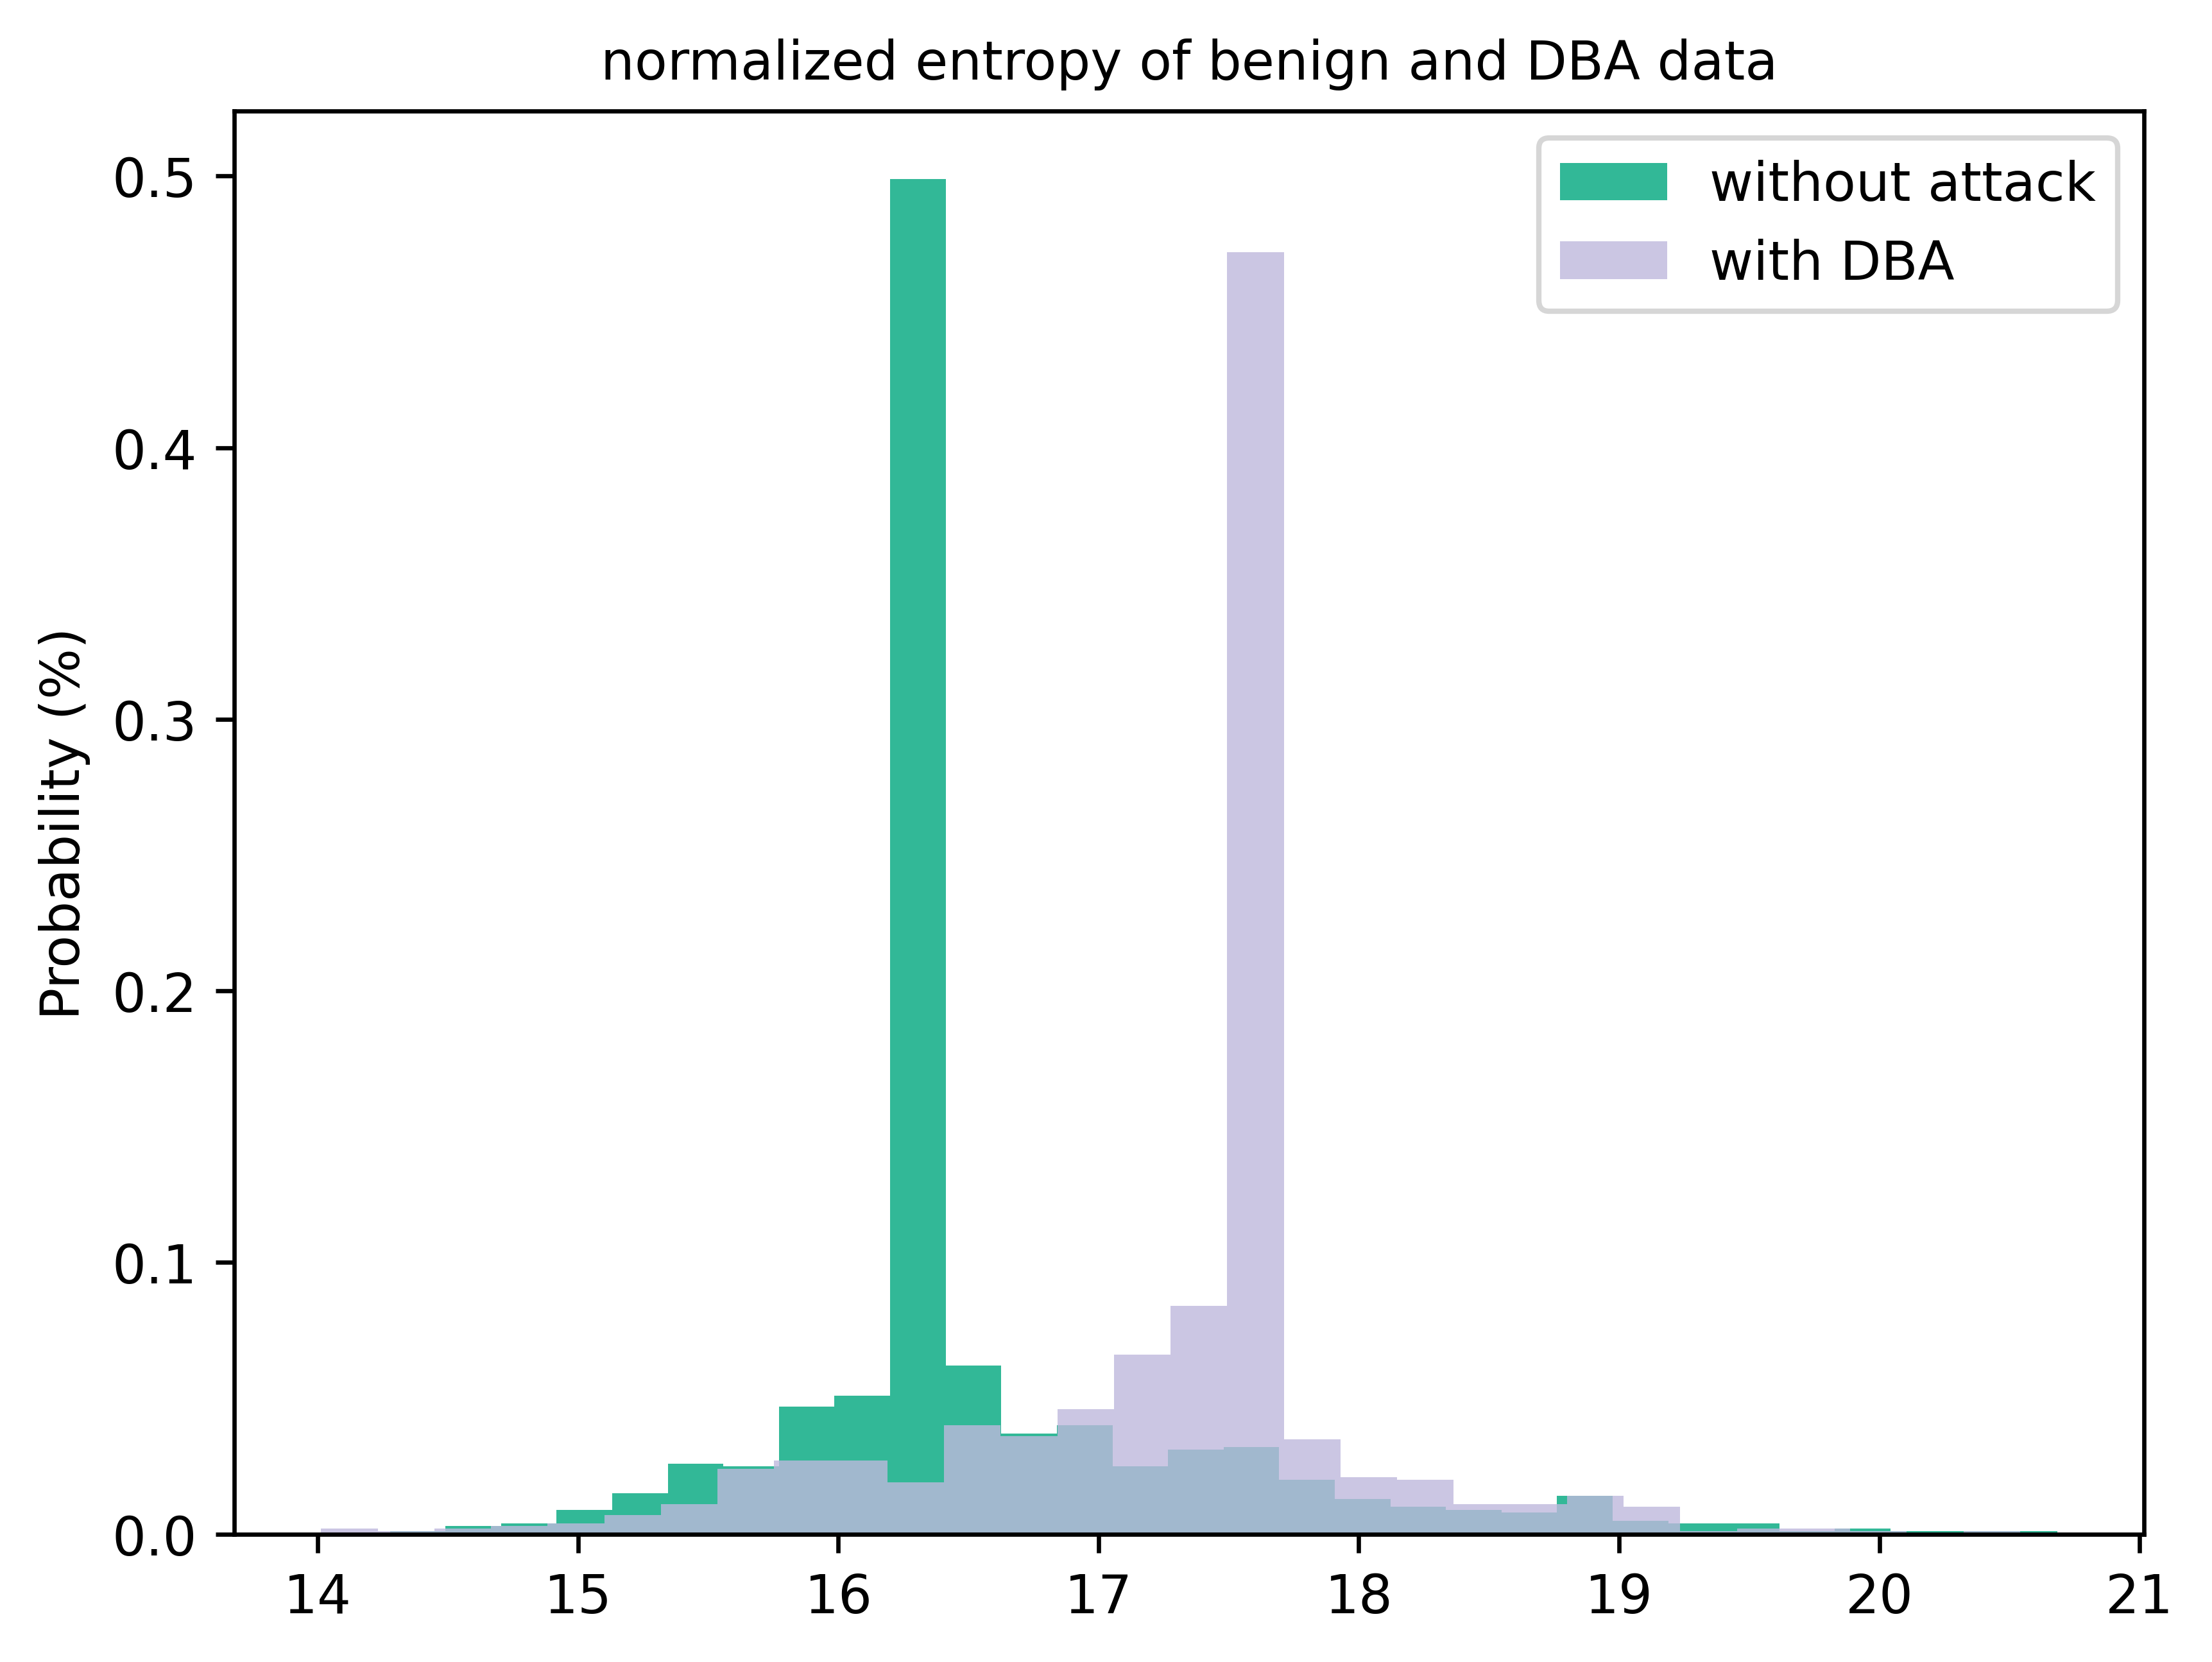

In [14]:
bins = 30
dpi = 600
alpha_b = 1
alpha = 0.8
color_benign = '#32B897'
color_patch = '#FFBE7A'
color_poison = '#FA7F6F'
color_DBA = '#BEB8DC'


plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("F:\exp_org_pic\cifar100-STRIP/benign-benign.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack, bins, weights=np.ones(len(EntropySum_attack)) / len(EntropySum_attack), color = color_patch, alpha=alpha, label='with BadNets')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and BadNets data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("F:\exp_org_pic\cifar100-STRIP/benign-benign2BadNets.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack_poison, bins, weights=np.ones(len(EntropySum_attack_poison)) / len(EntropySum_attack_poison), color = color_poison, alpha=alpha, label='with SRB')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and SRB data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("F:\exp_org_pic\cifar100-STRIP/benign-benign2SRB.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack_DBA, bins, weights=np.ones(len(EntropySum_attack_DBA)) / len(EntropySum_attack_DBA), color = color_DBA, alpha=alpha, label='with DBA')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and DBA data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("F:\exp_org_pic\cifar100-STRIP/benign-benign2DBA.tiff")
png1.close()
plt.show()

# org && org+trigger 的熵 对比，poison差别不大，patch趋势差别很大，
# no attack 和 poison 和 patch在benign数据下的熵的对比

In [4]:
# patched model
params = torch.load("F:\SAVE_MODEL\cifar100 Patched\Backdoor_saved_models_update1_noniid_100_cifar100_EC0_EE5791\maskratio1.0/Backdoor_model_cifar100_resnet_maskRatio1.0_Snorm_0.2_checkpoint_model_epoch_3840.pth")


file_benign = 'F:\datasets\cifar100\cifar-100-python/test'
file_attack = 'F:\datasets\cifar100\patch_cifar100/test'
file_attack_poison = 'F:\datasets\cifar100\poison_cifar100/test'
file_attack_DBA = 'F:\datasets\cifar100\DBA_cifar100/test'
dict = unpickle(file_benign)
model = ResNet34(num_classes=100)
model.cuda()

model.load_state_dict(params,False)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2,
                                                momentum=0.09,
                                                weight_decay=0.4)

fo = open(file_benign, 'rb')
label = pickle.load(fo, encoding='latin1')
fo.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_benign = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        num_random = random.randint(1,3333)
        image_trigger = np.reshape(dict.get("data")[i+num_random], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_benign[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_benign[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_benign)
        sum = sum + EntropySum_benign[k * 10 + i]
print(sum/100/10)
# print(EntropySum_benign)

# 100张 benign + 10次混合其他图片 在poison下信息熵均值为 -0.8485037518674508
# 100张 poison + 10次混合其他图片 在poison下信息熵均值为 -0.7518131062481552

# 100张 benign + 10次混合其他图片 在patch下信息熵均值为 8.130794444084168
# 100张 patch + 10次混合其他图片 在patch下信息熵均值为 7.389559324502945
dict = unpickle(file_attack)
f1 = open(file_attack, 'rb')
label = pickle.load(f1, encoding='latin1')
f1.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack)
        sum = sum + EntropySum_attack[k * 10 + i]
print(sum/100/10)

dict = unpickle(file_attack_poison)
f2 = open(file_attack_poison, 'rb')
label = pickle.load(f2, encoding='latin1')
f2.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack_poison = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack_poison[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack_poison[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack_poison)
        sum = sum + EntropySum_attack_poison[k * 10 + i]
print(sum/100/10)

dict = unpickle(file_attack_DBA)
f2 = open(file_attack_DBA, 'rb')
label = pickle.load(f2, encoding='latin1')
f2.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack_DBA = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        num_random = random.randint(1,6333)
        image_trigger = np.reshape(dict.get("data")[i+num_random], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack_DBA[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack_DBA[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack_DBA)
        sum = sum + EntropySum_attack_DBA[k * 10 + i]
print(sum/100/10)

d:\Anaconda3\envs\xwdneurotoxin\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1664\2245613841.py:55: RuntimeWarning: invalid value encountered in log2
  EntropySum_benign[k * 10 + i] = -np.nansum(output*np.log2(output))


7.495615399837495


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1664\2245613841.py:103: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack[k * 10 + i] = -np.nansum(output*np.log2(output))


6.361164606094361


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1664\2245613841.py:145: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack_poison[k * 10 + i] = -np.nansum(output*np.log2(output))


7.40081412601471


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1664\2245613841.py:188: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack_DBA[k * 10 + i] = -np.nansum(output*np.log2(output))


7.209601470708847


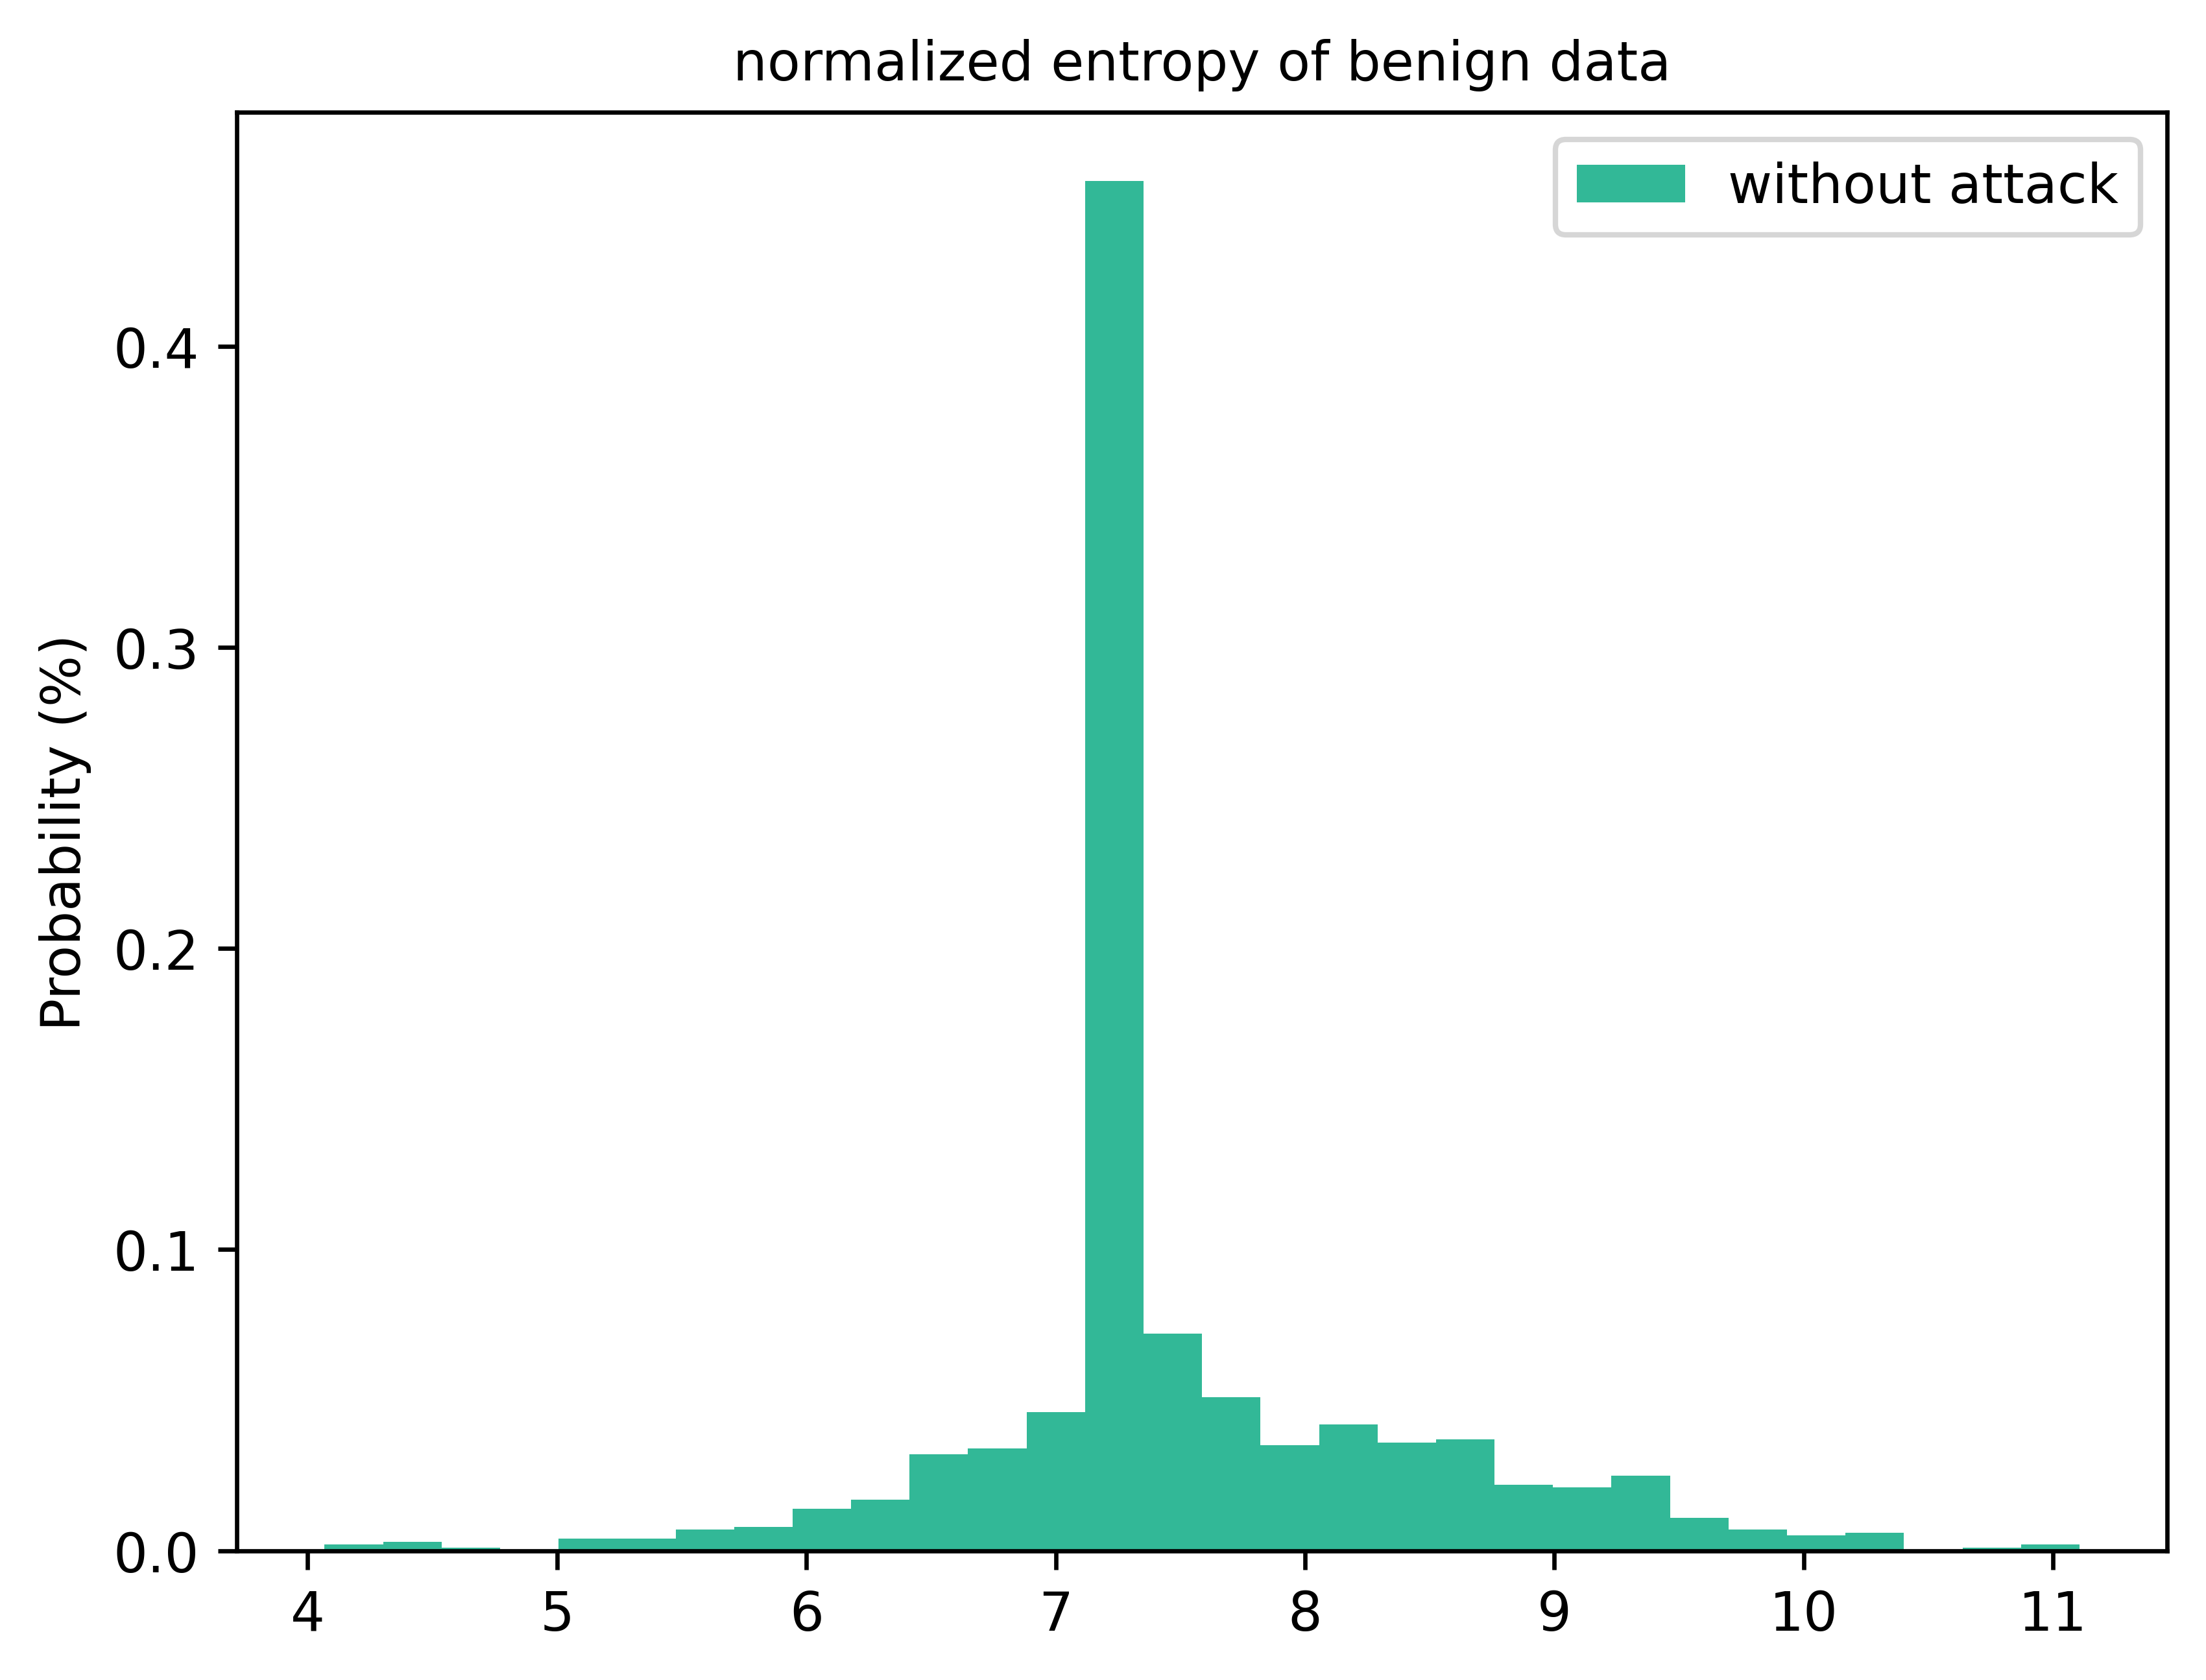

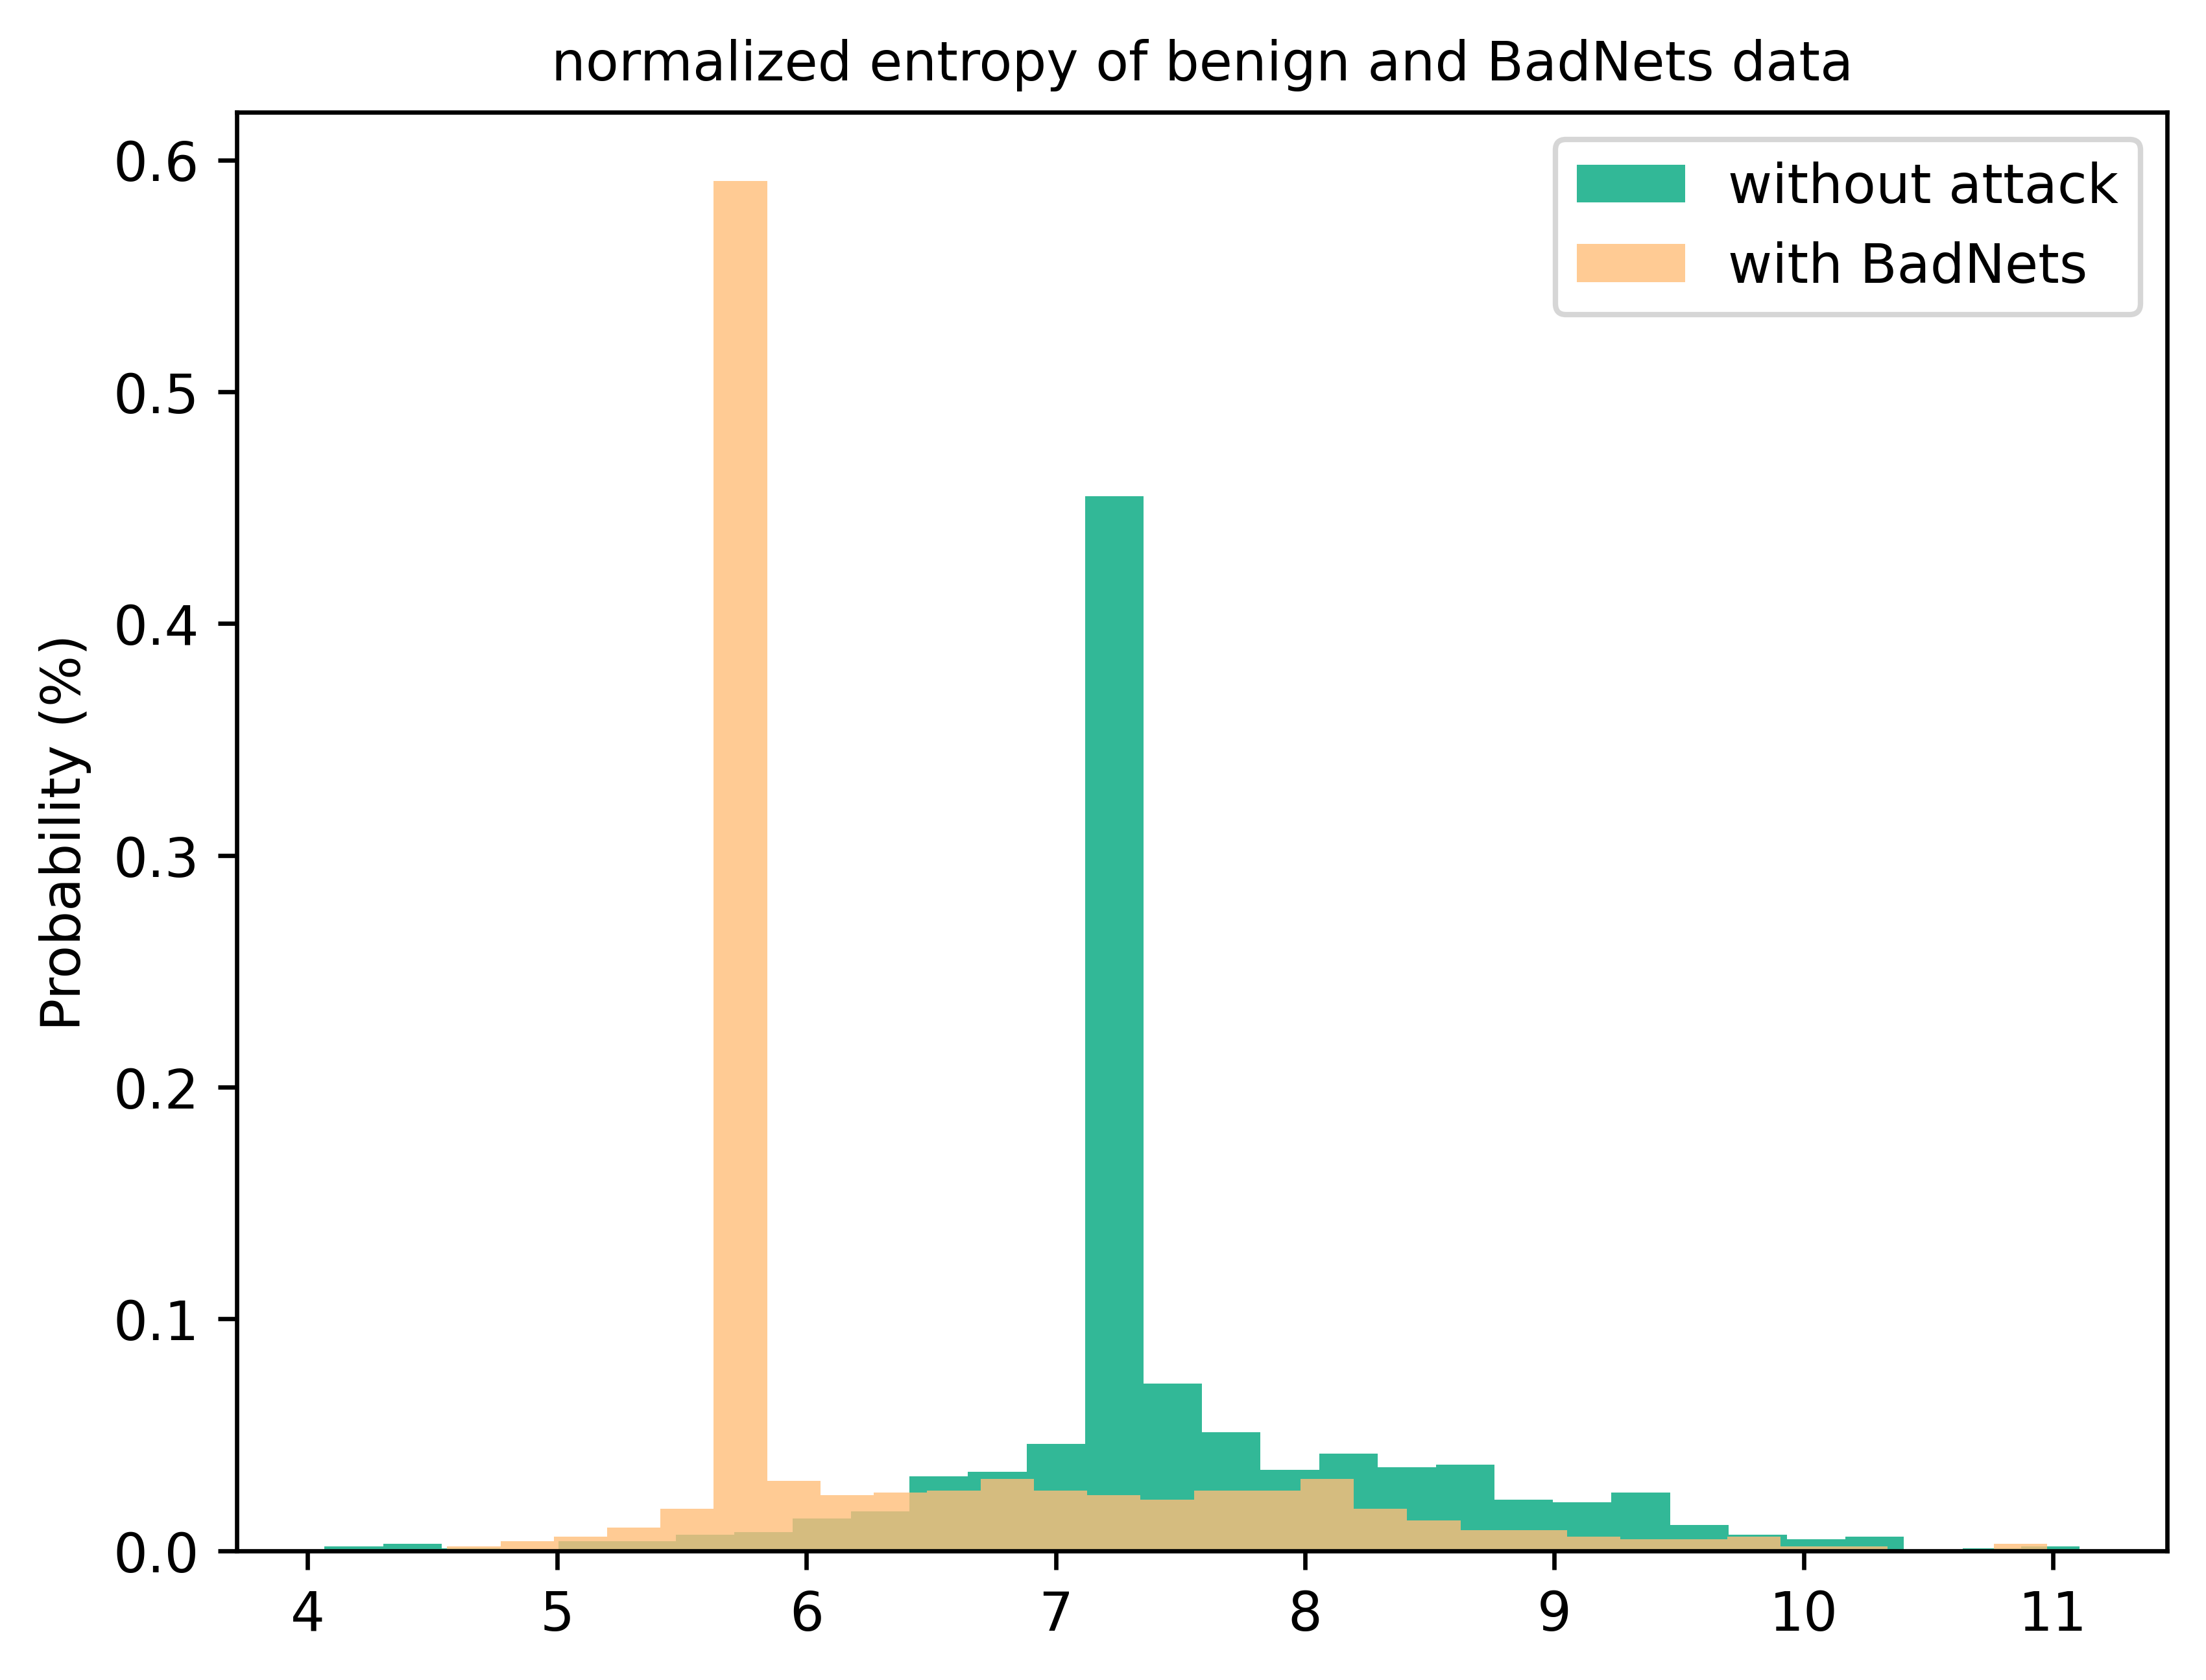

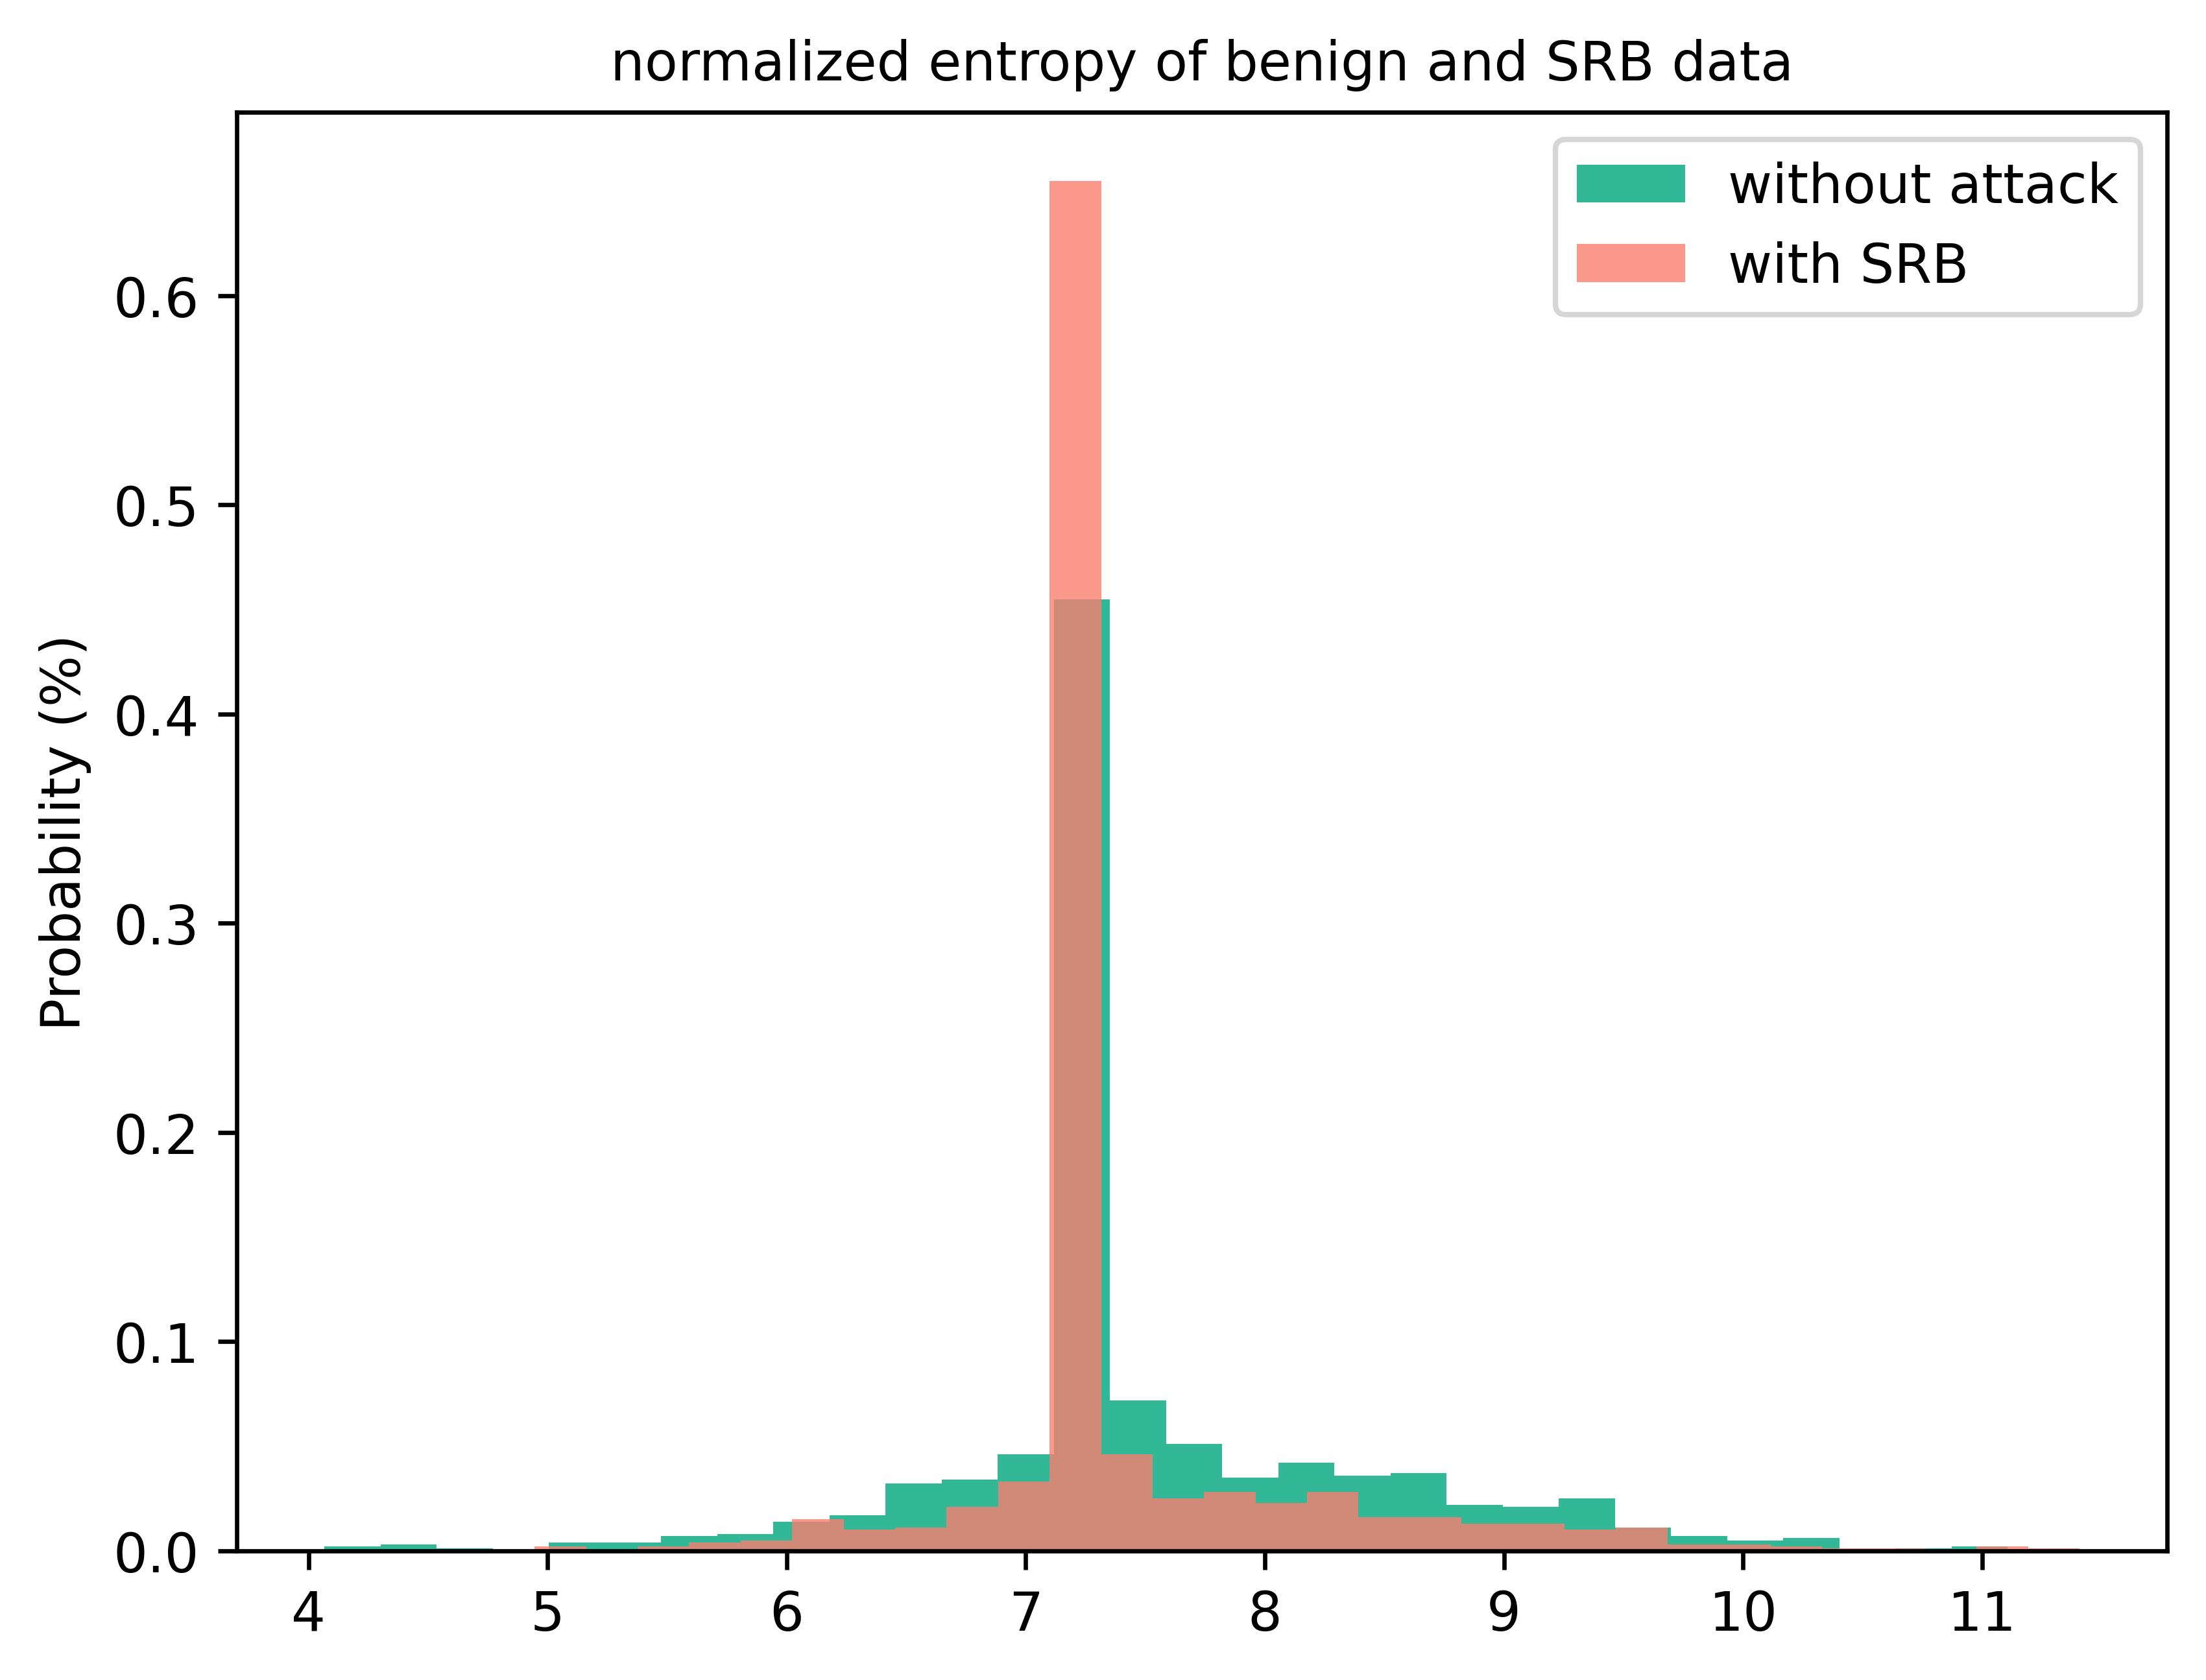

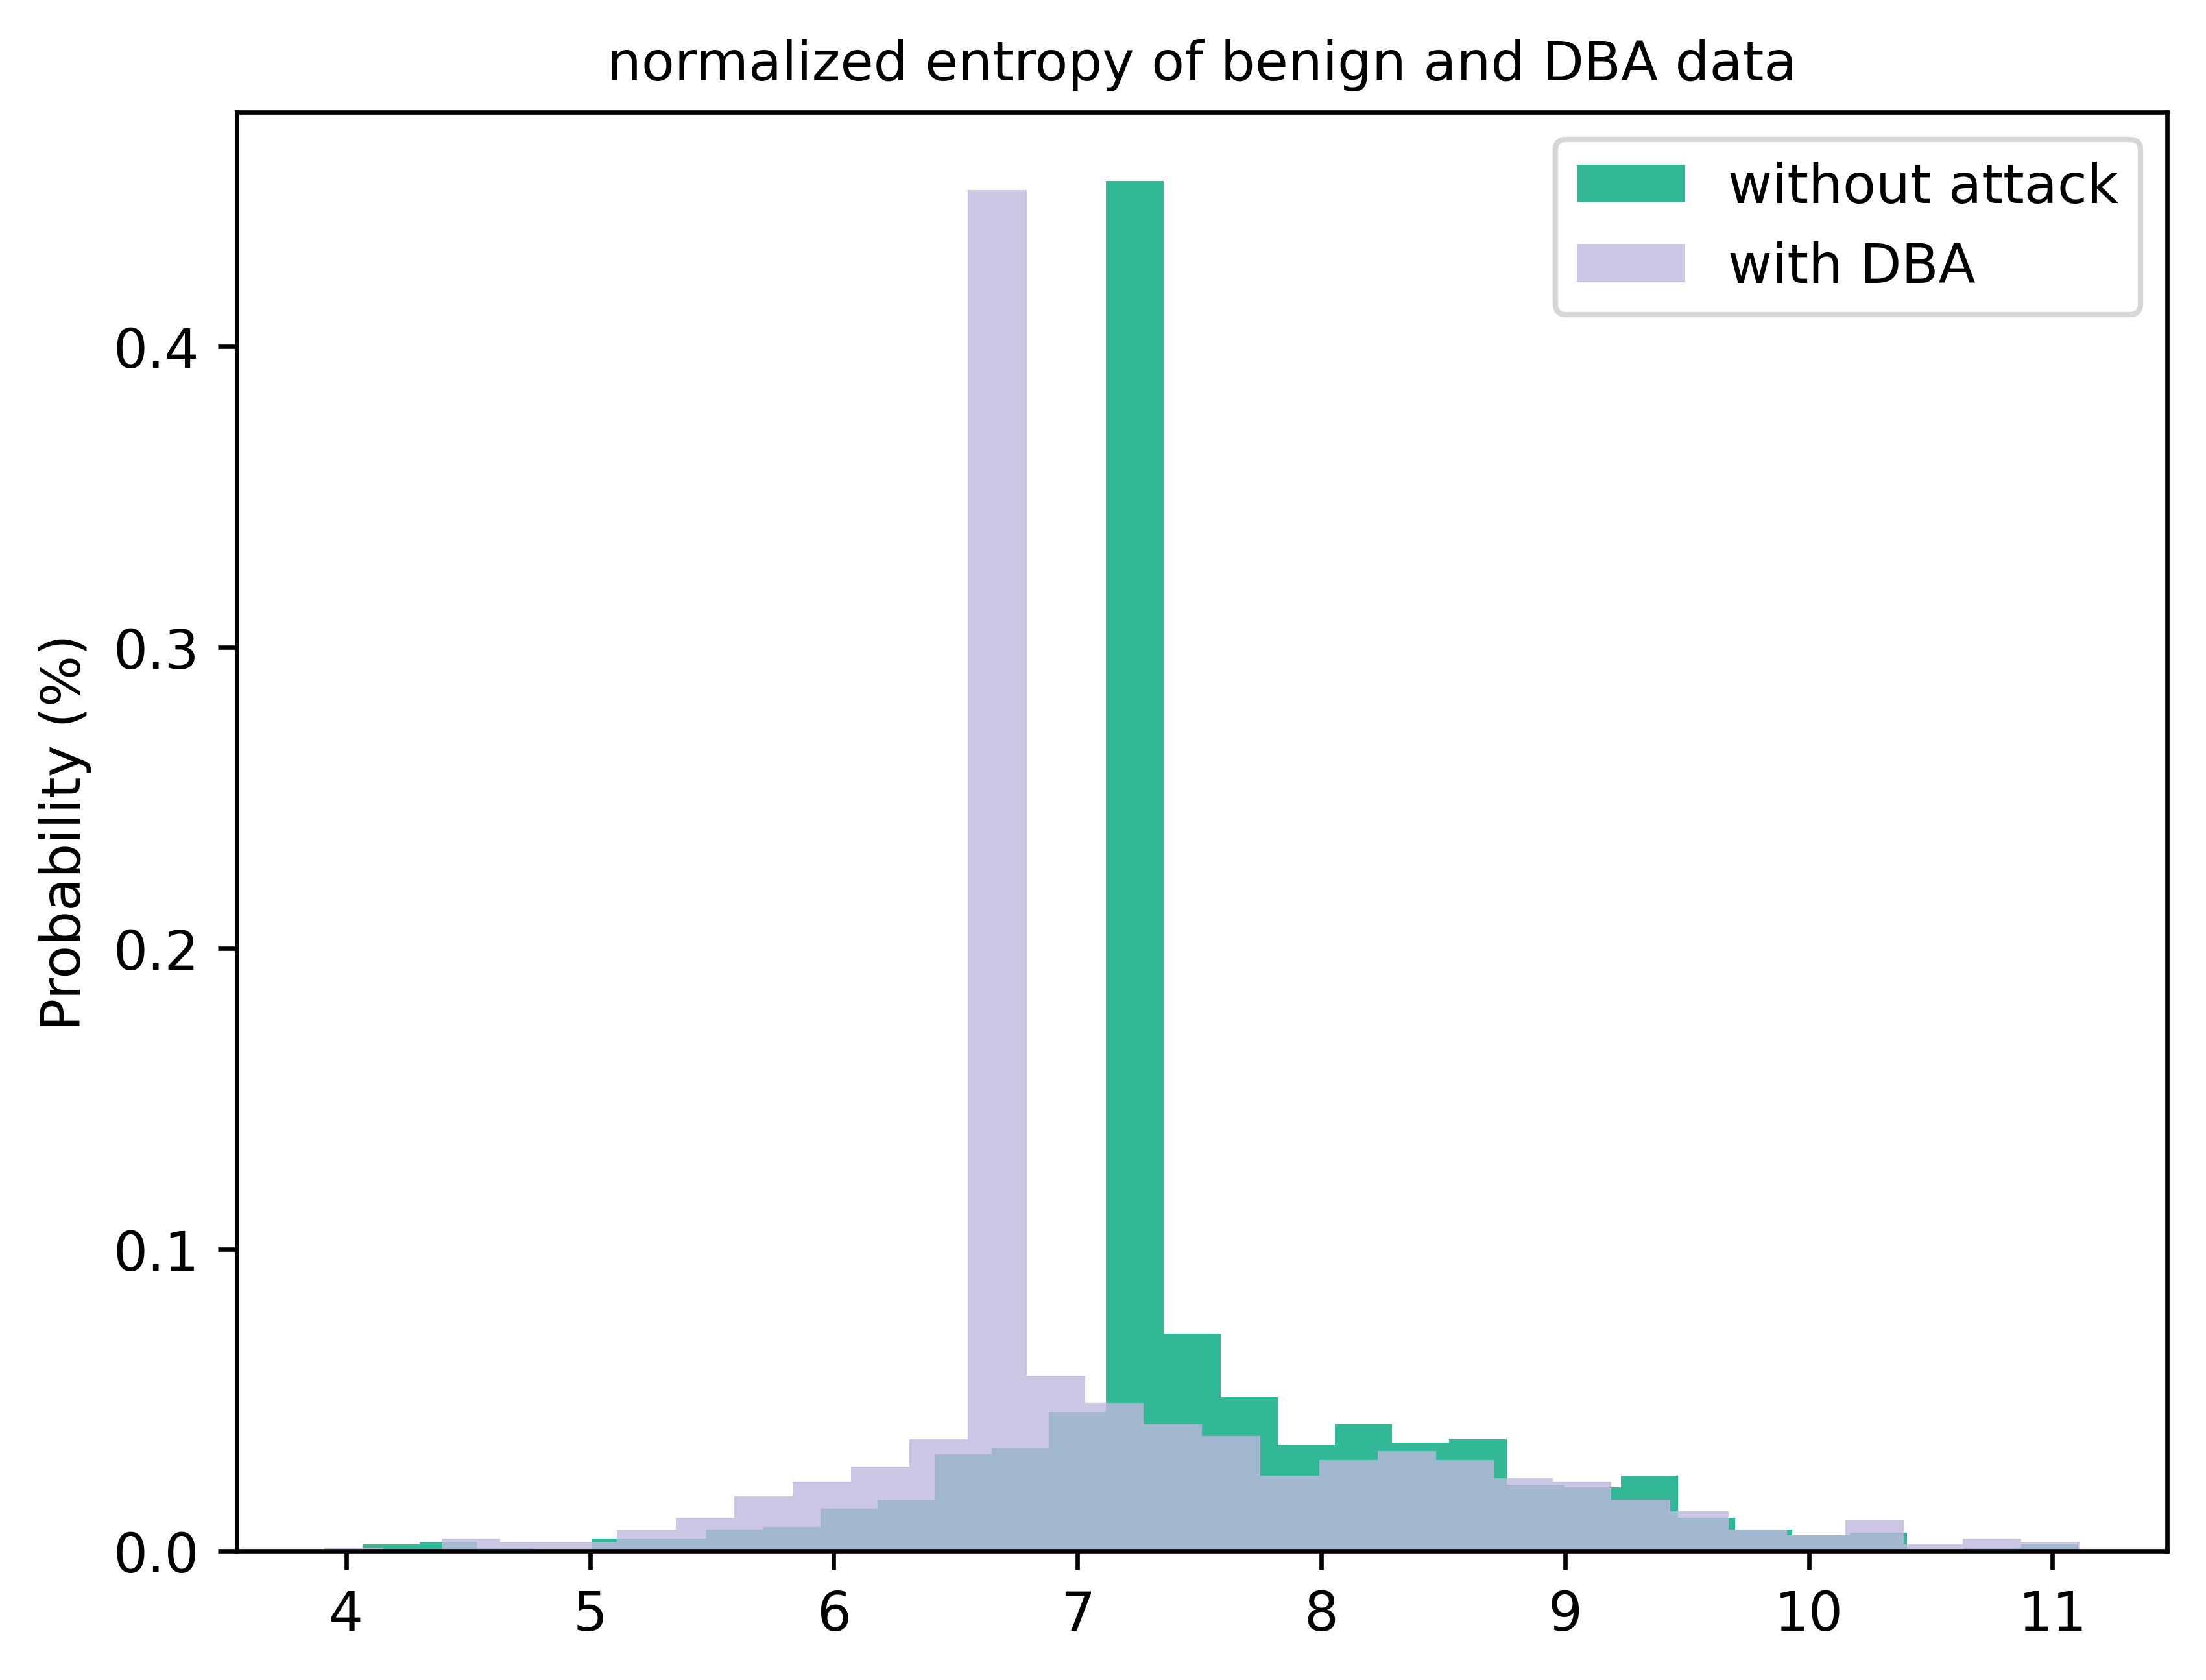

In [5]:
bins = 30
dpi = 600
alpha_b = 1
alpha = 0.8
color_benign = '#32B897'
color_patch = '#FFBE7A'
color_poison = '#FA7F6F'
color_DBA = '#BEB8DC'


plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("F:\exp_org_pic\cifar100-STRIP/BadNets-benign.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack, bins, weights=np.ones(len(EntropySum_attack)) / len(EntropySum_attack), color = color_patch, alpha=alpha, label='with BadNets')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and BadNets data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("F:\exp_org_pic\cifar100-STRIP/BadNets-benign2BadNets.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack_poison, bins, weights=np.ones(len(EntropySum_attack_poison)) / len(EntropySum_attack_poison), color = color_poison, alpha=alpha, label='with SRB')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and SRB data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("F:\exp_org_pic\cifar100-STRIP/BadNets-benign2SRB.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack_DBA, bins, weights=np.ones(len(EntropySum_attack_DBA)) / len(EntropySum_attack_DBA), color = color_DBA, alpha=alpha, label='with DBA')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and DBA data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("F:\exp_org_pic\cifar100-STRIP/BadNets-benign2DBA.tiff")
png1.close()
plt.show()

# org && org+trigger 的熵 对比，poison差别不大，patch趋势差别很大，
# no attack 和 poison 和 patch在benign数据下的熵的对比

In [6]:
# poisoned model
params = torch.load("F:\SAVE_MODEL\cifar100 poison/Attacker_model_epoch_1900.pth")


file_benign = 'F:\datasets\cifar100\cifar-100-python/test'
file_attack = 'F:\datasets\cifar100\patch_cifar100/test'
file_attack_poison = 'F:\datasets\cifar100\poison_cifar100/test'
file_attack_DBA = 'F:\datasets\cifar100\DBA_cifar100/test'
dict = unpickle(file_benign)
model = ResNet34(num_classes=100)
model.cuda()

model.load_state_dict(params)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2,
                                                momentum=0.09,
                                                weight_decay=0.4)

fo = open(file_benign, 'rb')
label = pickle.load(fo, encoding='latin1')
fo.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_benign = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        num_random = random.randint(1,3333)
        image_trigger = np.reshape(dict.get("data")[i+num_random], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_benign[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_benign[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_benign)
        sum = sum + EntropySum_benign[k * 10 + i]
print(sum/100/10)
# print(EntropySum_benign)

# 100张 benign + 10次混合其他图片 在poison下信息熵均值为 -0.8485037518674508
# 100张 poison + 10次混合其他图片 在poison下信息熵均值为 -0.7518131062481552

# 100张 benign + 10次混合其他图片 在patch下信息熵均值为 8.130794444084168
# 100张 patch + 10次混合其他图片 在patch下信息熵均值为 7.389559324502945
dict = unpickle(file_attack)
f1 = open(file_attack, 'rb')
label = pickle.load(f1, encoding='latin1')
f1.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack)
        sum = sum + EntropySum_attack[k * 10 + i]
print(sum/100/10)

dict = unpickle(file_attack_poison)
f2 = open(file_attack_poison, 'rb')
label = pickle.load(f2, encoding='latin1')
f2.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack_poison = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack_poison[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack_poison[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack_poison)
        sum = sum + EntropySum_attack_poison[k * 10 + i]
print(sum/100/10)

dict = unpickle(file_attack_DBA)
f2 = open(file_attack_DBA, 'rb')
label = pickle.load(f2, encoding='latin1')
f2.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack_DBA = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack_DBA[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack_DBA[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack_DBA)
        sum = sum + EntropySum_attack_DBA[k * 10 + i]
print(sum/100/10)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1664\3530259433.py:55: RuntimeWarning: invalid value encountered in log2
  EntropySum_benign[k * 10 + i] = -np.nansum(output*np.log2(output))


11.063299863815308


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1664\3530259433.py:103: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack[k * 10 + i] = -np.nansum(output*np.log2(output))


10.332246836662293


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1664\3530259433.py:145: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack_poison[k * 10 + i] = -np.nansum(output*np.log2(output))


10.869673759460449


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1664\3530259433.py:187: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack_DBA[k * 10 + i] = -np.nansum(output*np.log2(output))


11.19759070968628


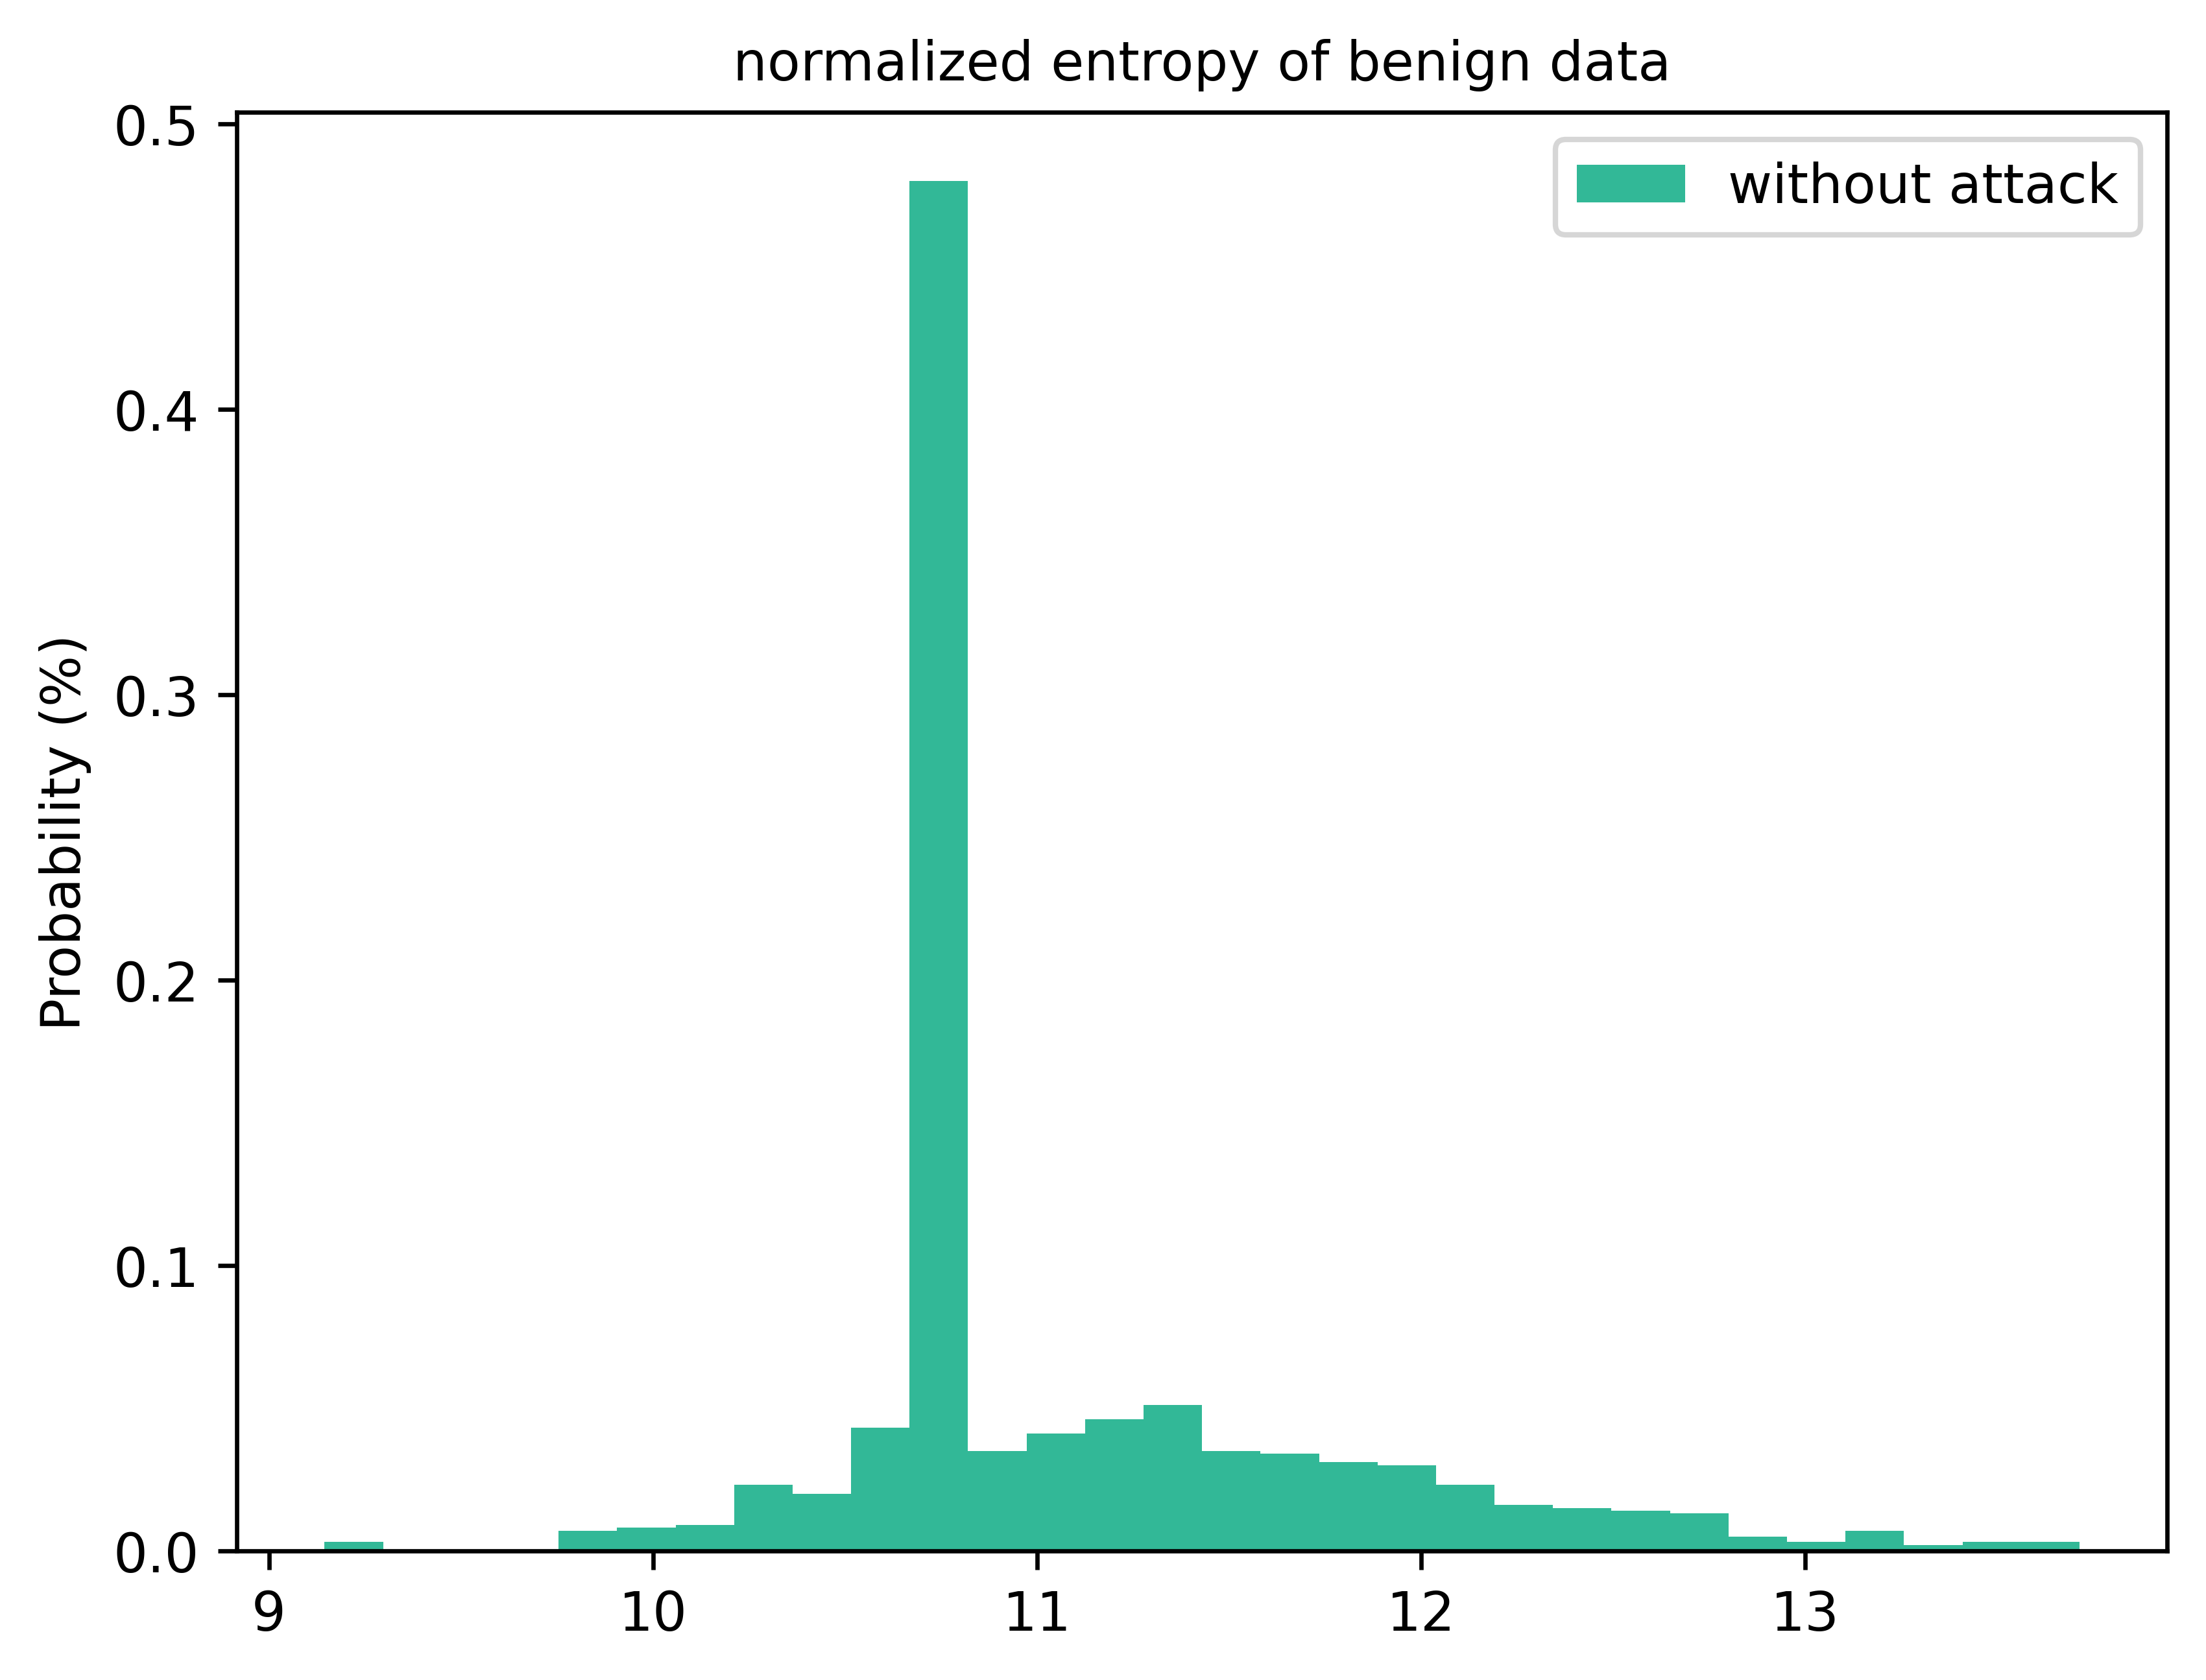

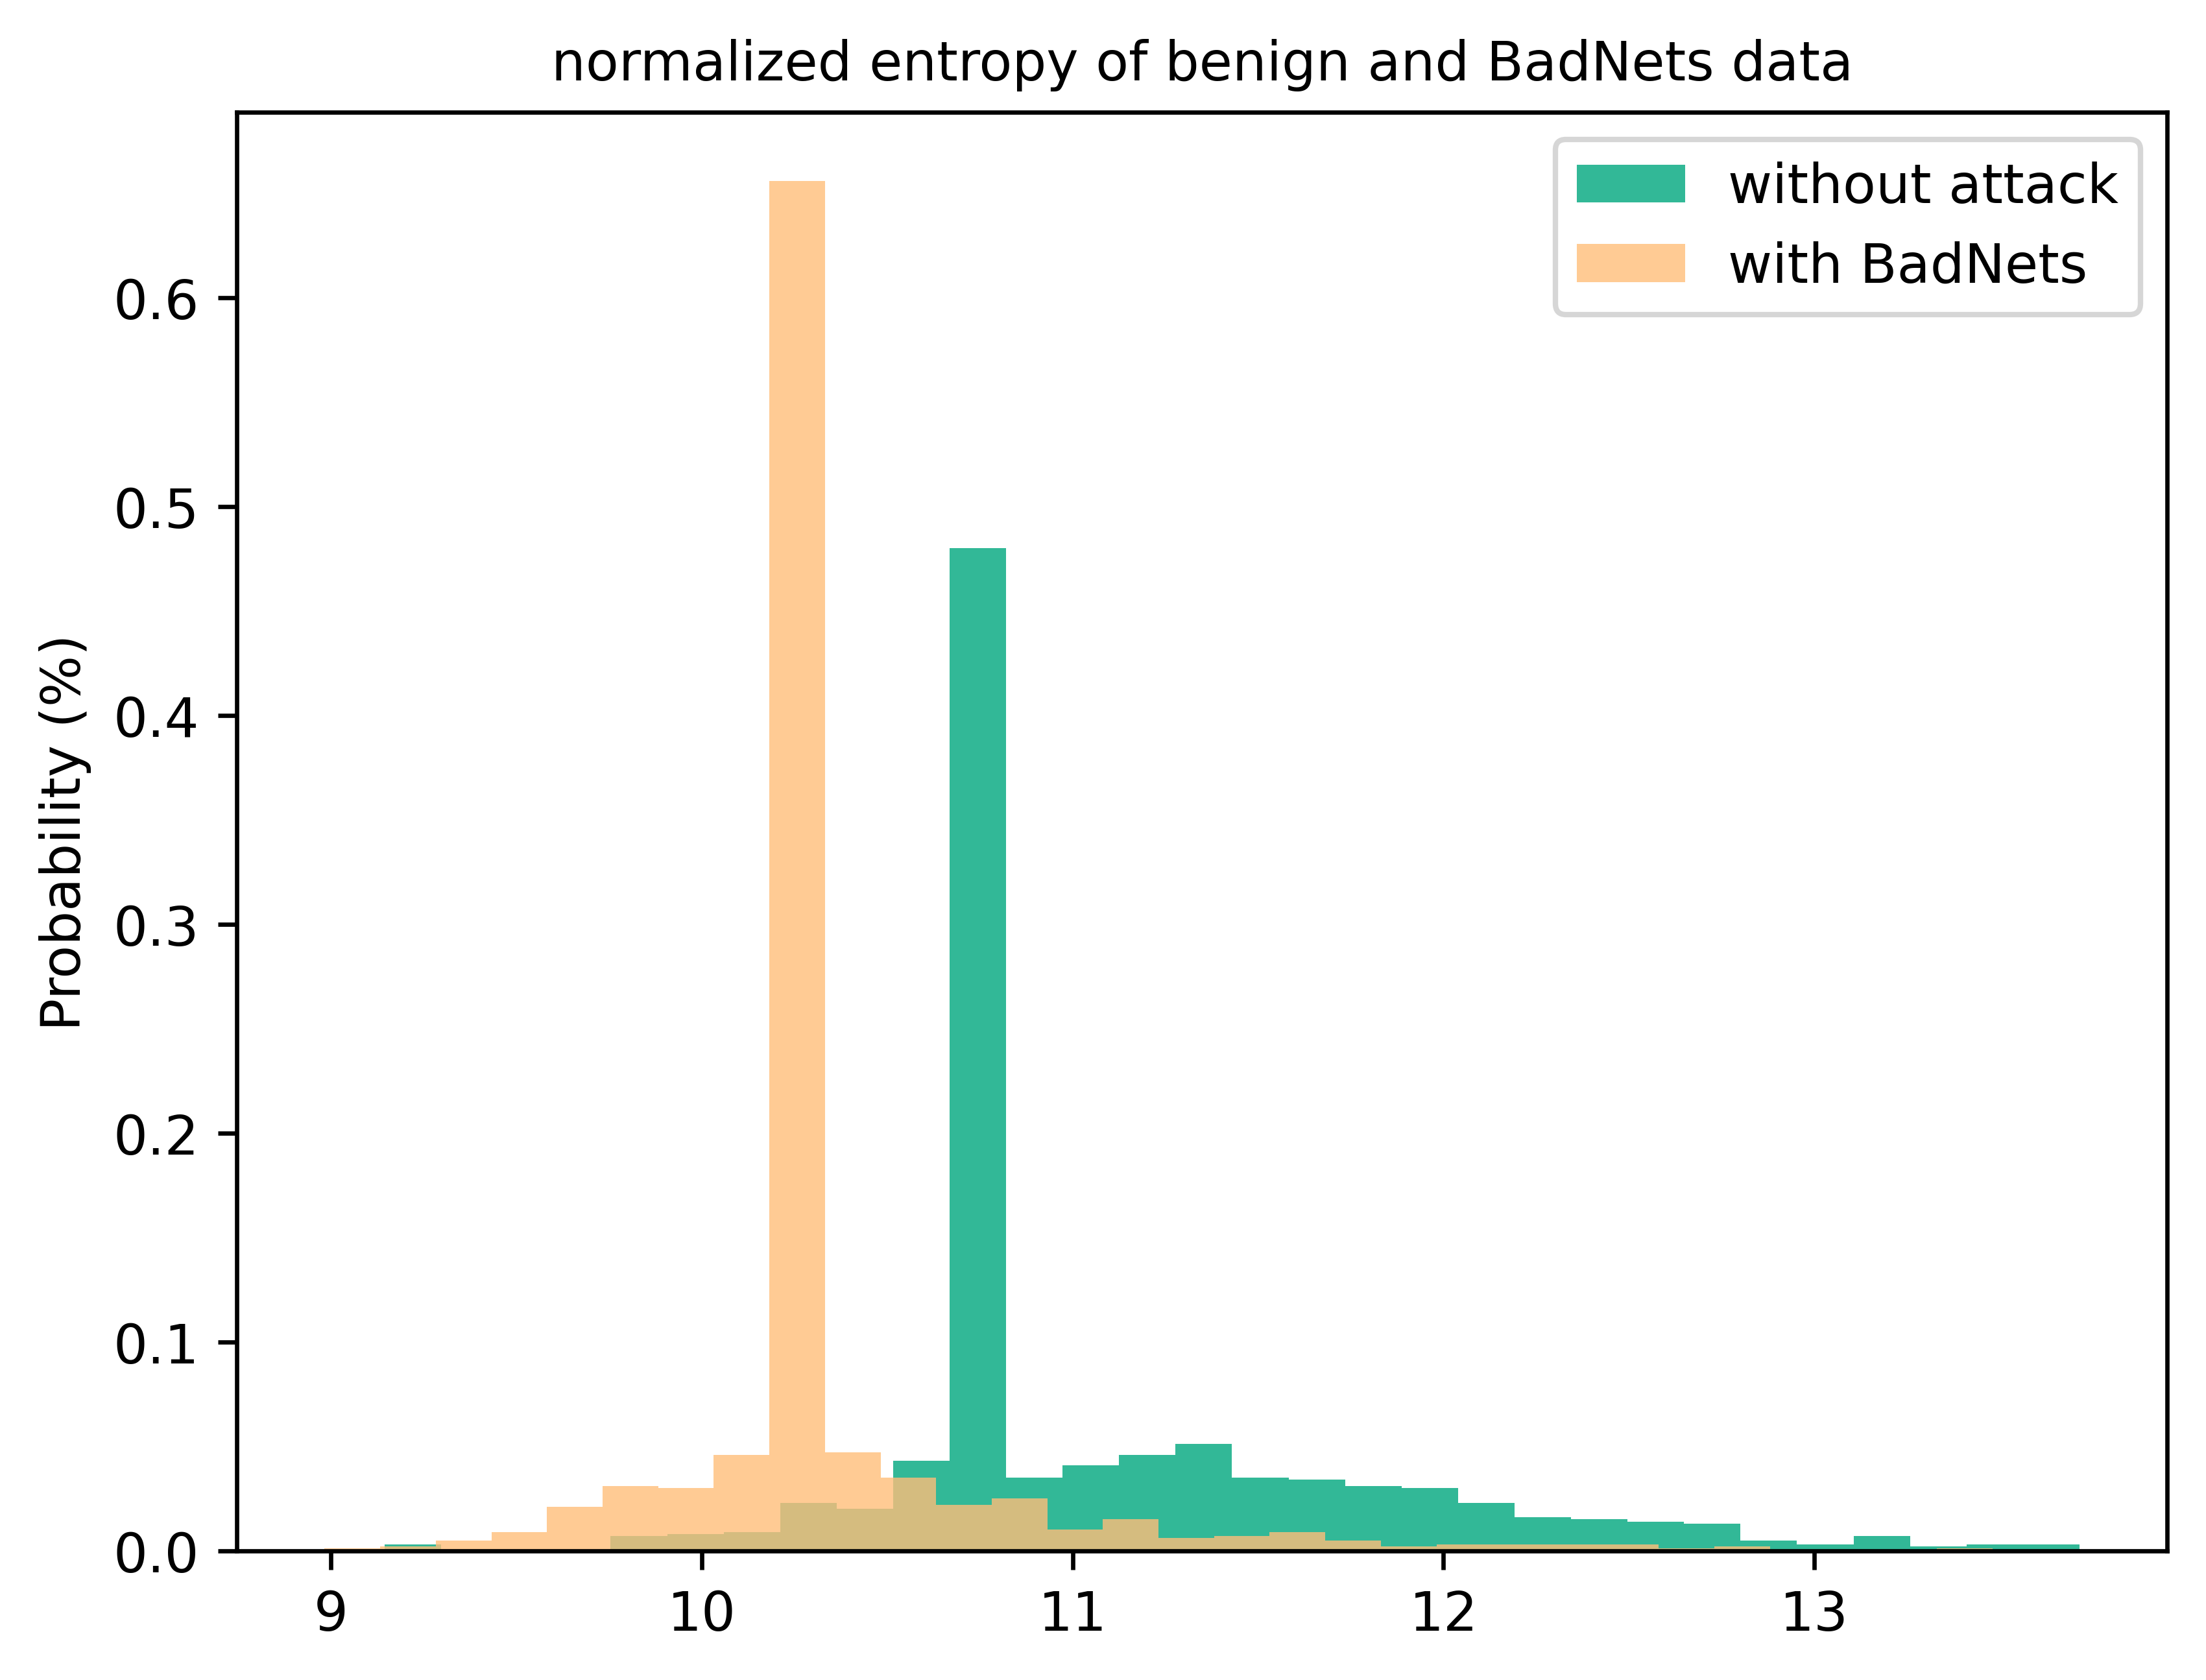

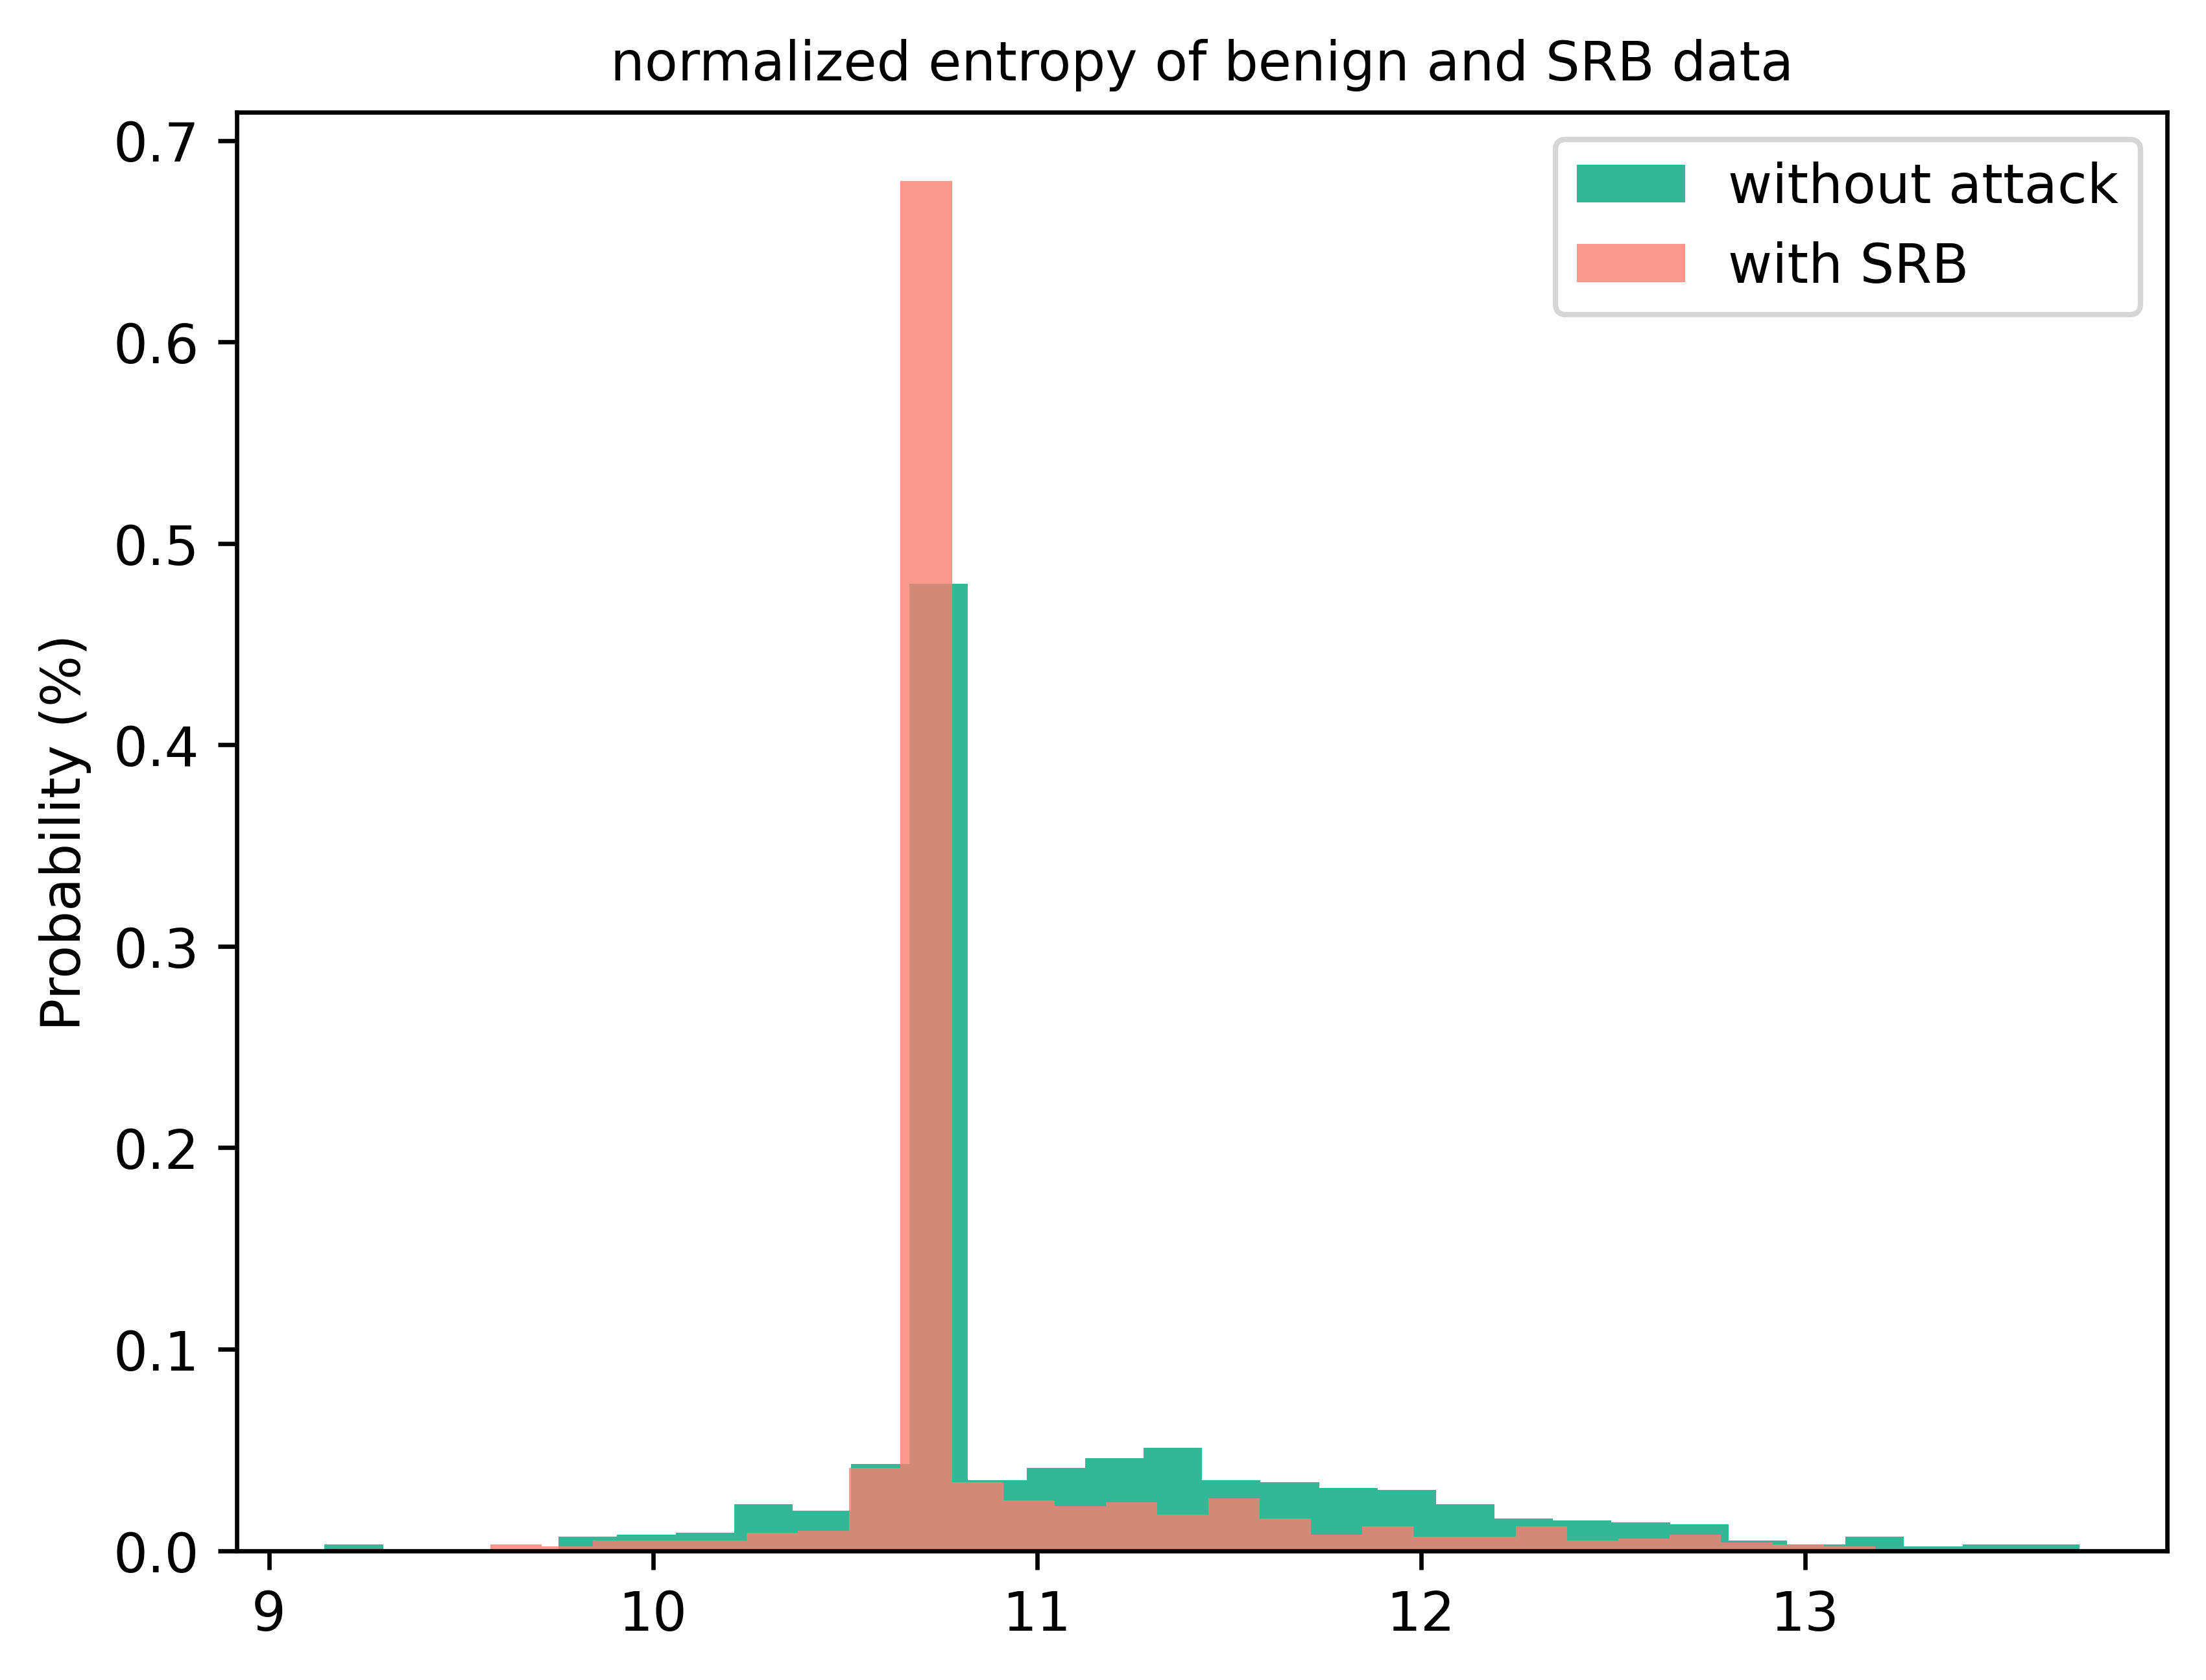

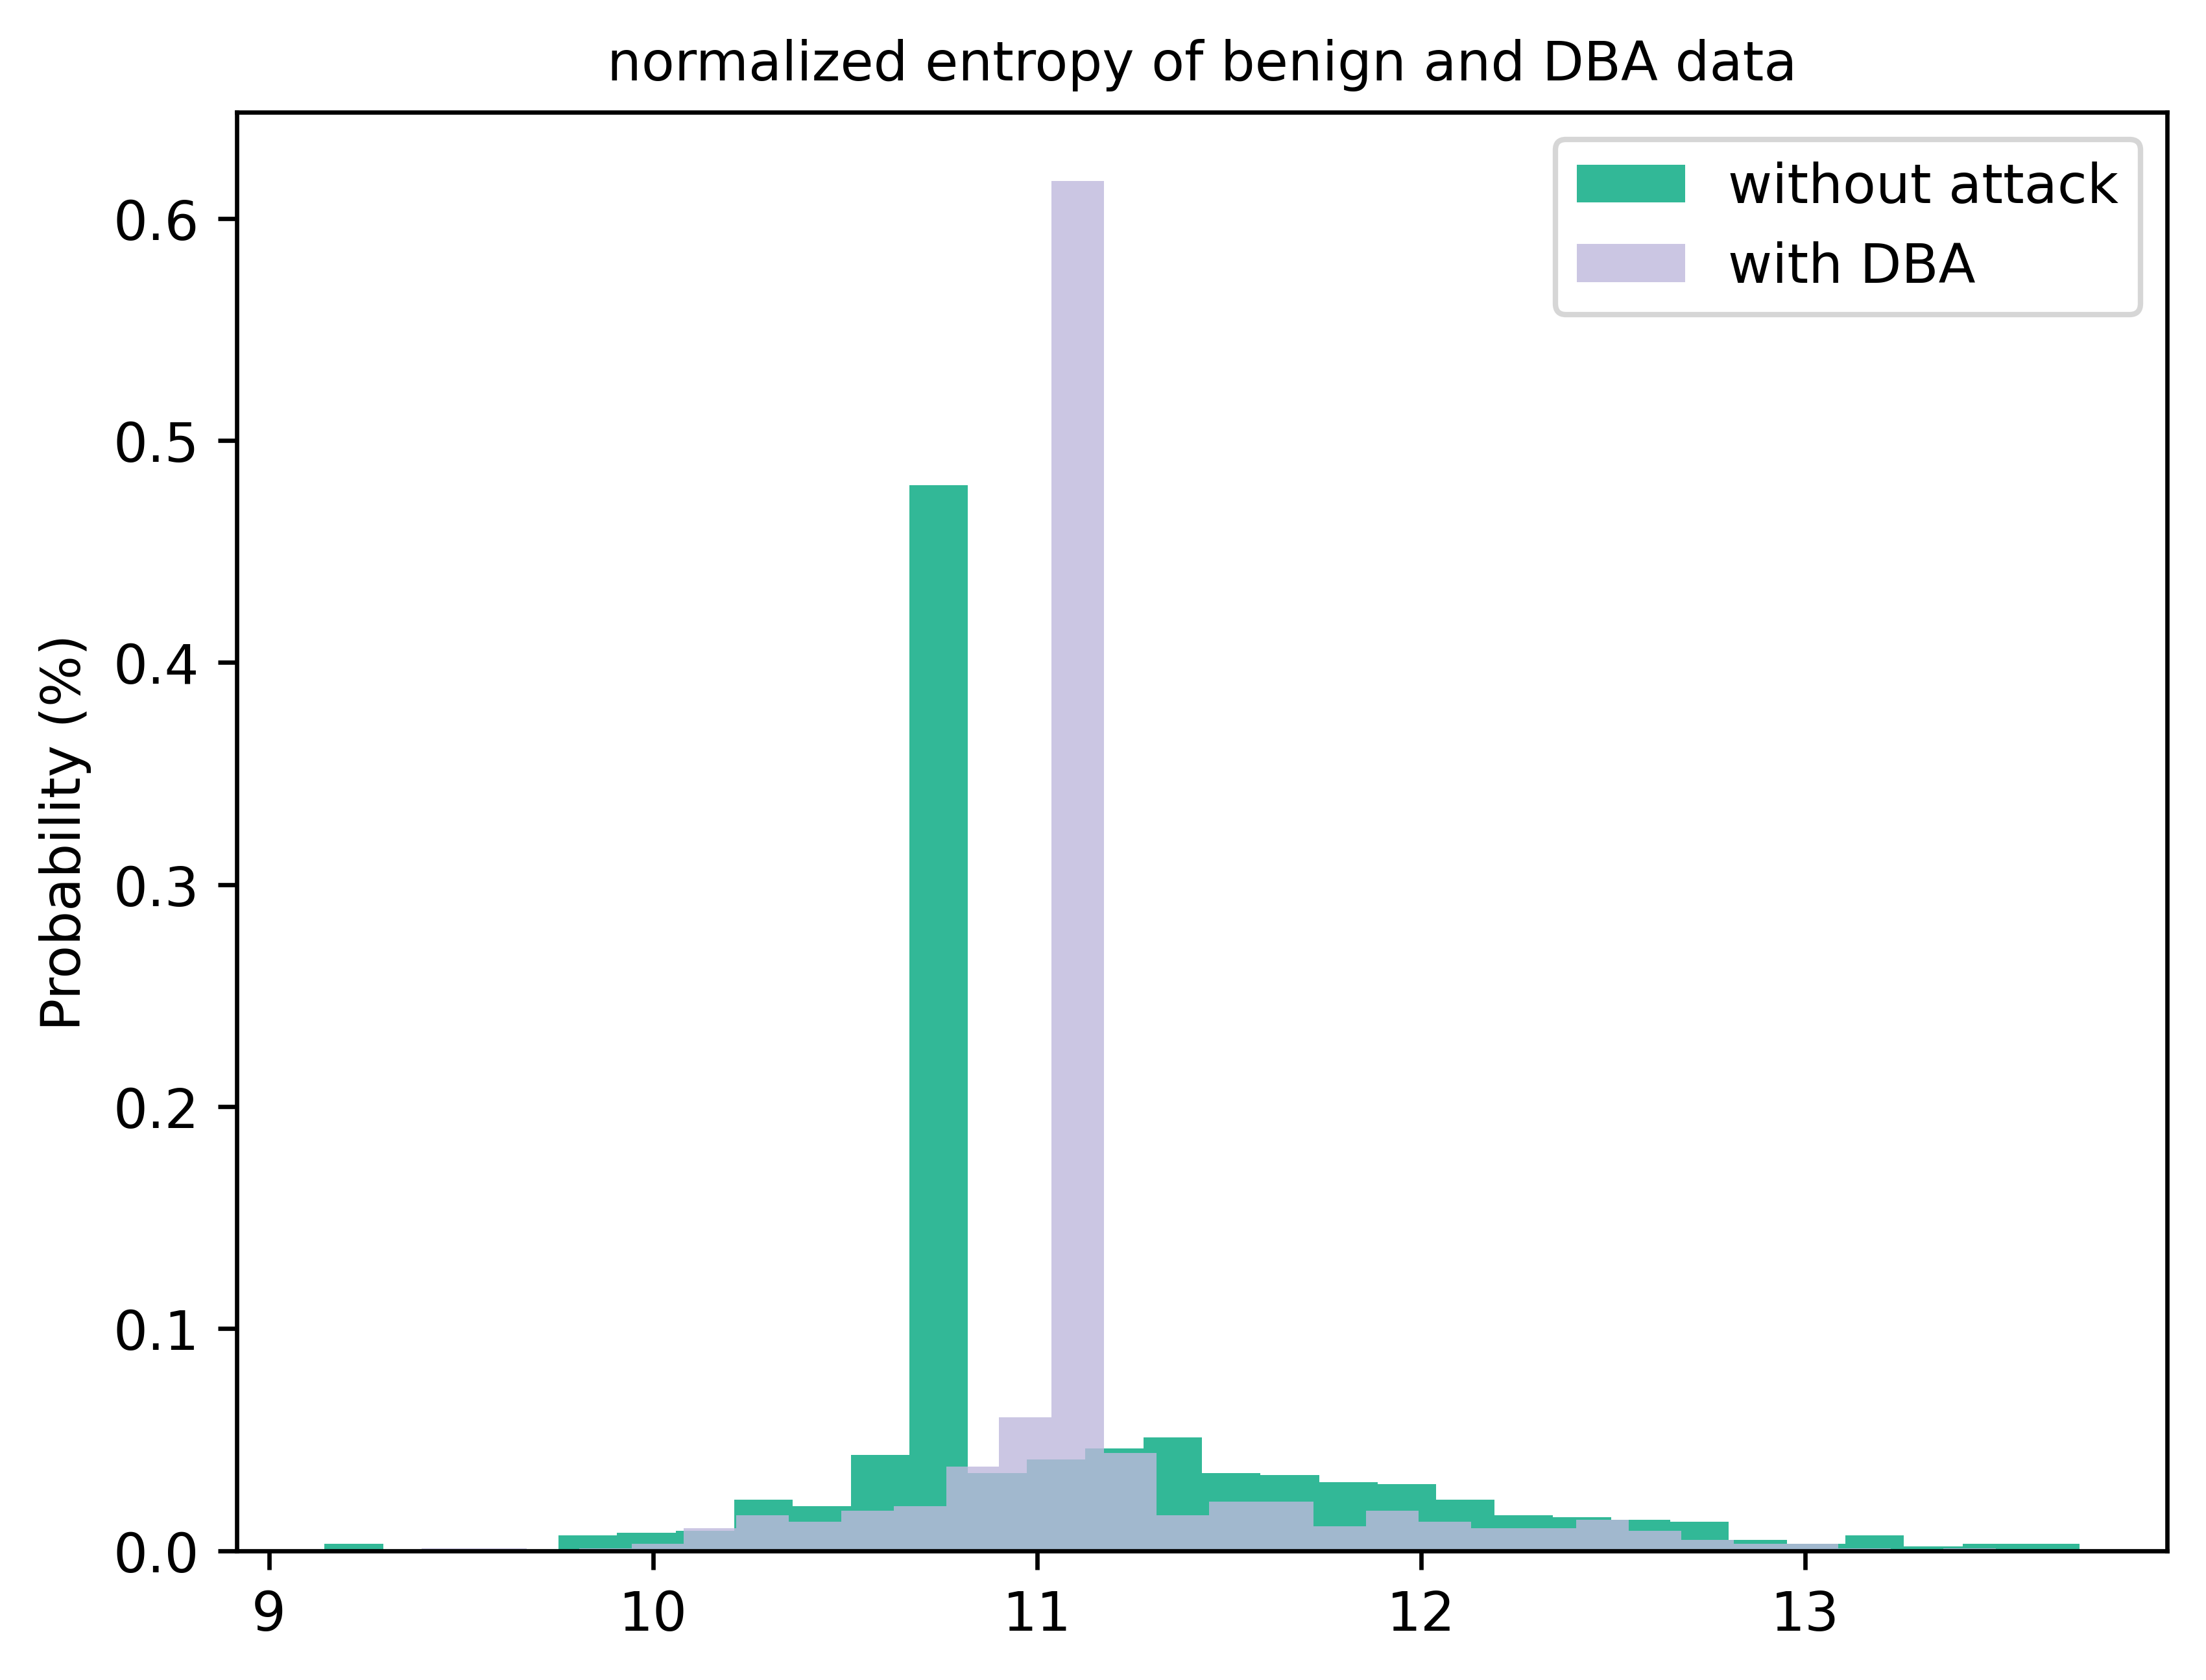

In [7]:
bins = 30
dpi = 600
alpha_b = 1
alpha = 0.8
color_benign = '#32B897'
color_patch = '#FFBE7A'
color_poison = '#FA7F6F'
color_DBA = '#BEB8DC'


plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("F:\exp_org_pic\cifar100-STRIP/SRB-benign.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack, bins, weights=np.ones(len(EntropySum_attack)) / len(EntropySum_attack), color = color_patch, alpha=alpha, label='with BadNets')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and BadNets data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("F:\exp_org_pic\cifar100-STRIP/SRB-benign2BadNets.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack_poison, bins, weights=np.ones(len(EntropySum_attack_poison)) / len(EntropySum_attack_poison), color = color_poison, alpha=alpha, label='with SRB')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and SRB data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("F:\exp_org_pic\cifar100-STRIP/SRB-benign2SRB.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack_DBA, bins, weights=np.ones(len(EntropySum_attack_DBA)) / len(EntropySum_attack_DBA), color = color_DBA, alpha=alpha, label='with DBA')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and DBA data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("F:\exp_org_pic\cifar100-STRIP/SRB-benign2DBA.tiff")
png1.close()
plt.show()

# org && org+trigger 的熵 对比，poison差别不大，patch趋势差别很大，
# no attack 和 poison 和 patch在benign数据下的熵的对比

In [8]:
# DBA model
params = torch.load("F:\SAVE_MODEL\cifar100 DBA/【估计是效果差的】Backdoor_model_cifar100_resnet_maskRatio1.0_Snorm_0.2_checkpoint_model_epoch_3800.pth")

file_benign = 'F:\datasets\cifar100\cifar-100-python/test'
file_attack = 'F:\datasets\cifar100\patch_cifar100/test'
file_attack_poison = 'F:\datasets\cifar100\poison_cifar100/test'
file_attack_DBA = 'F:\datasets\cifar100\DBA_cifar100/test'
dict = unpickle(file_benign)
model = ResNet34(num_classes=100)
model.cuda()

model.load_state_dict(params)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2,
                                                momentum=0.09,
                                                weight_decay=0.4)

fo = open(file_benign, 'rb')
label = pickle.load(fo, encoding='latin1')
fo.close()
labels = label.get("labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_benign = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        num_random = random.randint(1,3333)
        image_trigger = np.reshape(dict.get("data")[i+num_random], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_benign[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_benign[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_benign)
        sum = sum + EntropySum_benign[k * 10 + i]
print(sum/100/10)
# print(EntropySum_benign)

# 100张 benign + 10次混合其他图片 在poison下信息熵均值为 -0.8485037518674508
# 100张 poison + 10次混合其他图片 在poison下信息熵均值为 -0.7518131062481552

# 100张 benign + 10次混合其他图片 在patch下信息熵均值为 8.130794444084168
# 100张 patch + 10次混合其他图片 在patch下信息熵均值为 7.389559324502945
dict = unpickle(file_attack)
f1 = open(file_attack, 'rb')
label = pickle.load(f1, encoding='latin1')
f1.close()
labels = label.get("labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack)
        sum = sum + EntropySum_attack[k * 10 + i]
print(sum/100/10)

dict = unpickle(file_attack_poison)
f2 = open(file_attack_poison, 'rb')
label = pickle.load(f2, encoding='latin1')
f2.close()
labels = label.get("labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack_poison = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack_poison[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack_poison[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack_poison)
        sum = sum + EntropySum_attack_poison[k * 10 + i]
print(sum/100/10)

dict = unpickle(file_attack_DBA)
f2 = open(file_attack_DBA, 'rb')
label = pickle.load(f2, encoding='latin1')
f2.close()
labels = label.get("labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack_DBA = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack_DBA[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack_DBA[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack_DBA)
        sum = sum + EntropySum_attack_DBA[k * 10 + i]
print(sum/100/10)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1664\3797472454.py:54: RuntimeWarning: invalid value encountered in log2
  EntropySum_benign[k * 10 + i] = -np.nansum(output*np.log2(output))


13.463775036811828


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1664\3797472454.py:102: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack[k * 10 + i] = -np.nansum(output*np.log2(output))


15.969845380783081


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1664\3797472454.py:144: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack_poison[k * 10 + i] = -np.nansum(output*np.log2(output))


13.168092990875243


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1664\3797472454.py:186: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack_DBA[k * 10 + i] = -np.nansum(output*np.log2(output))


14.51655984401703


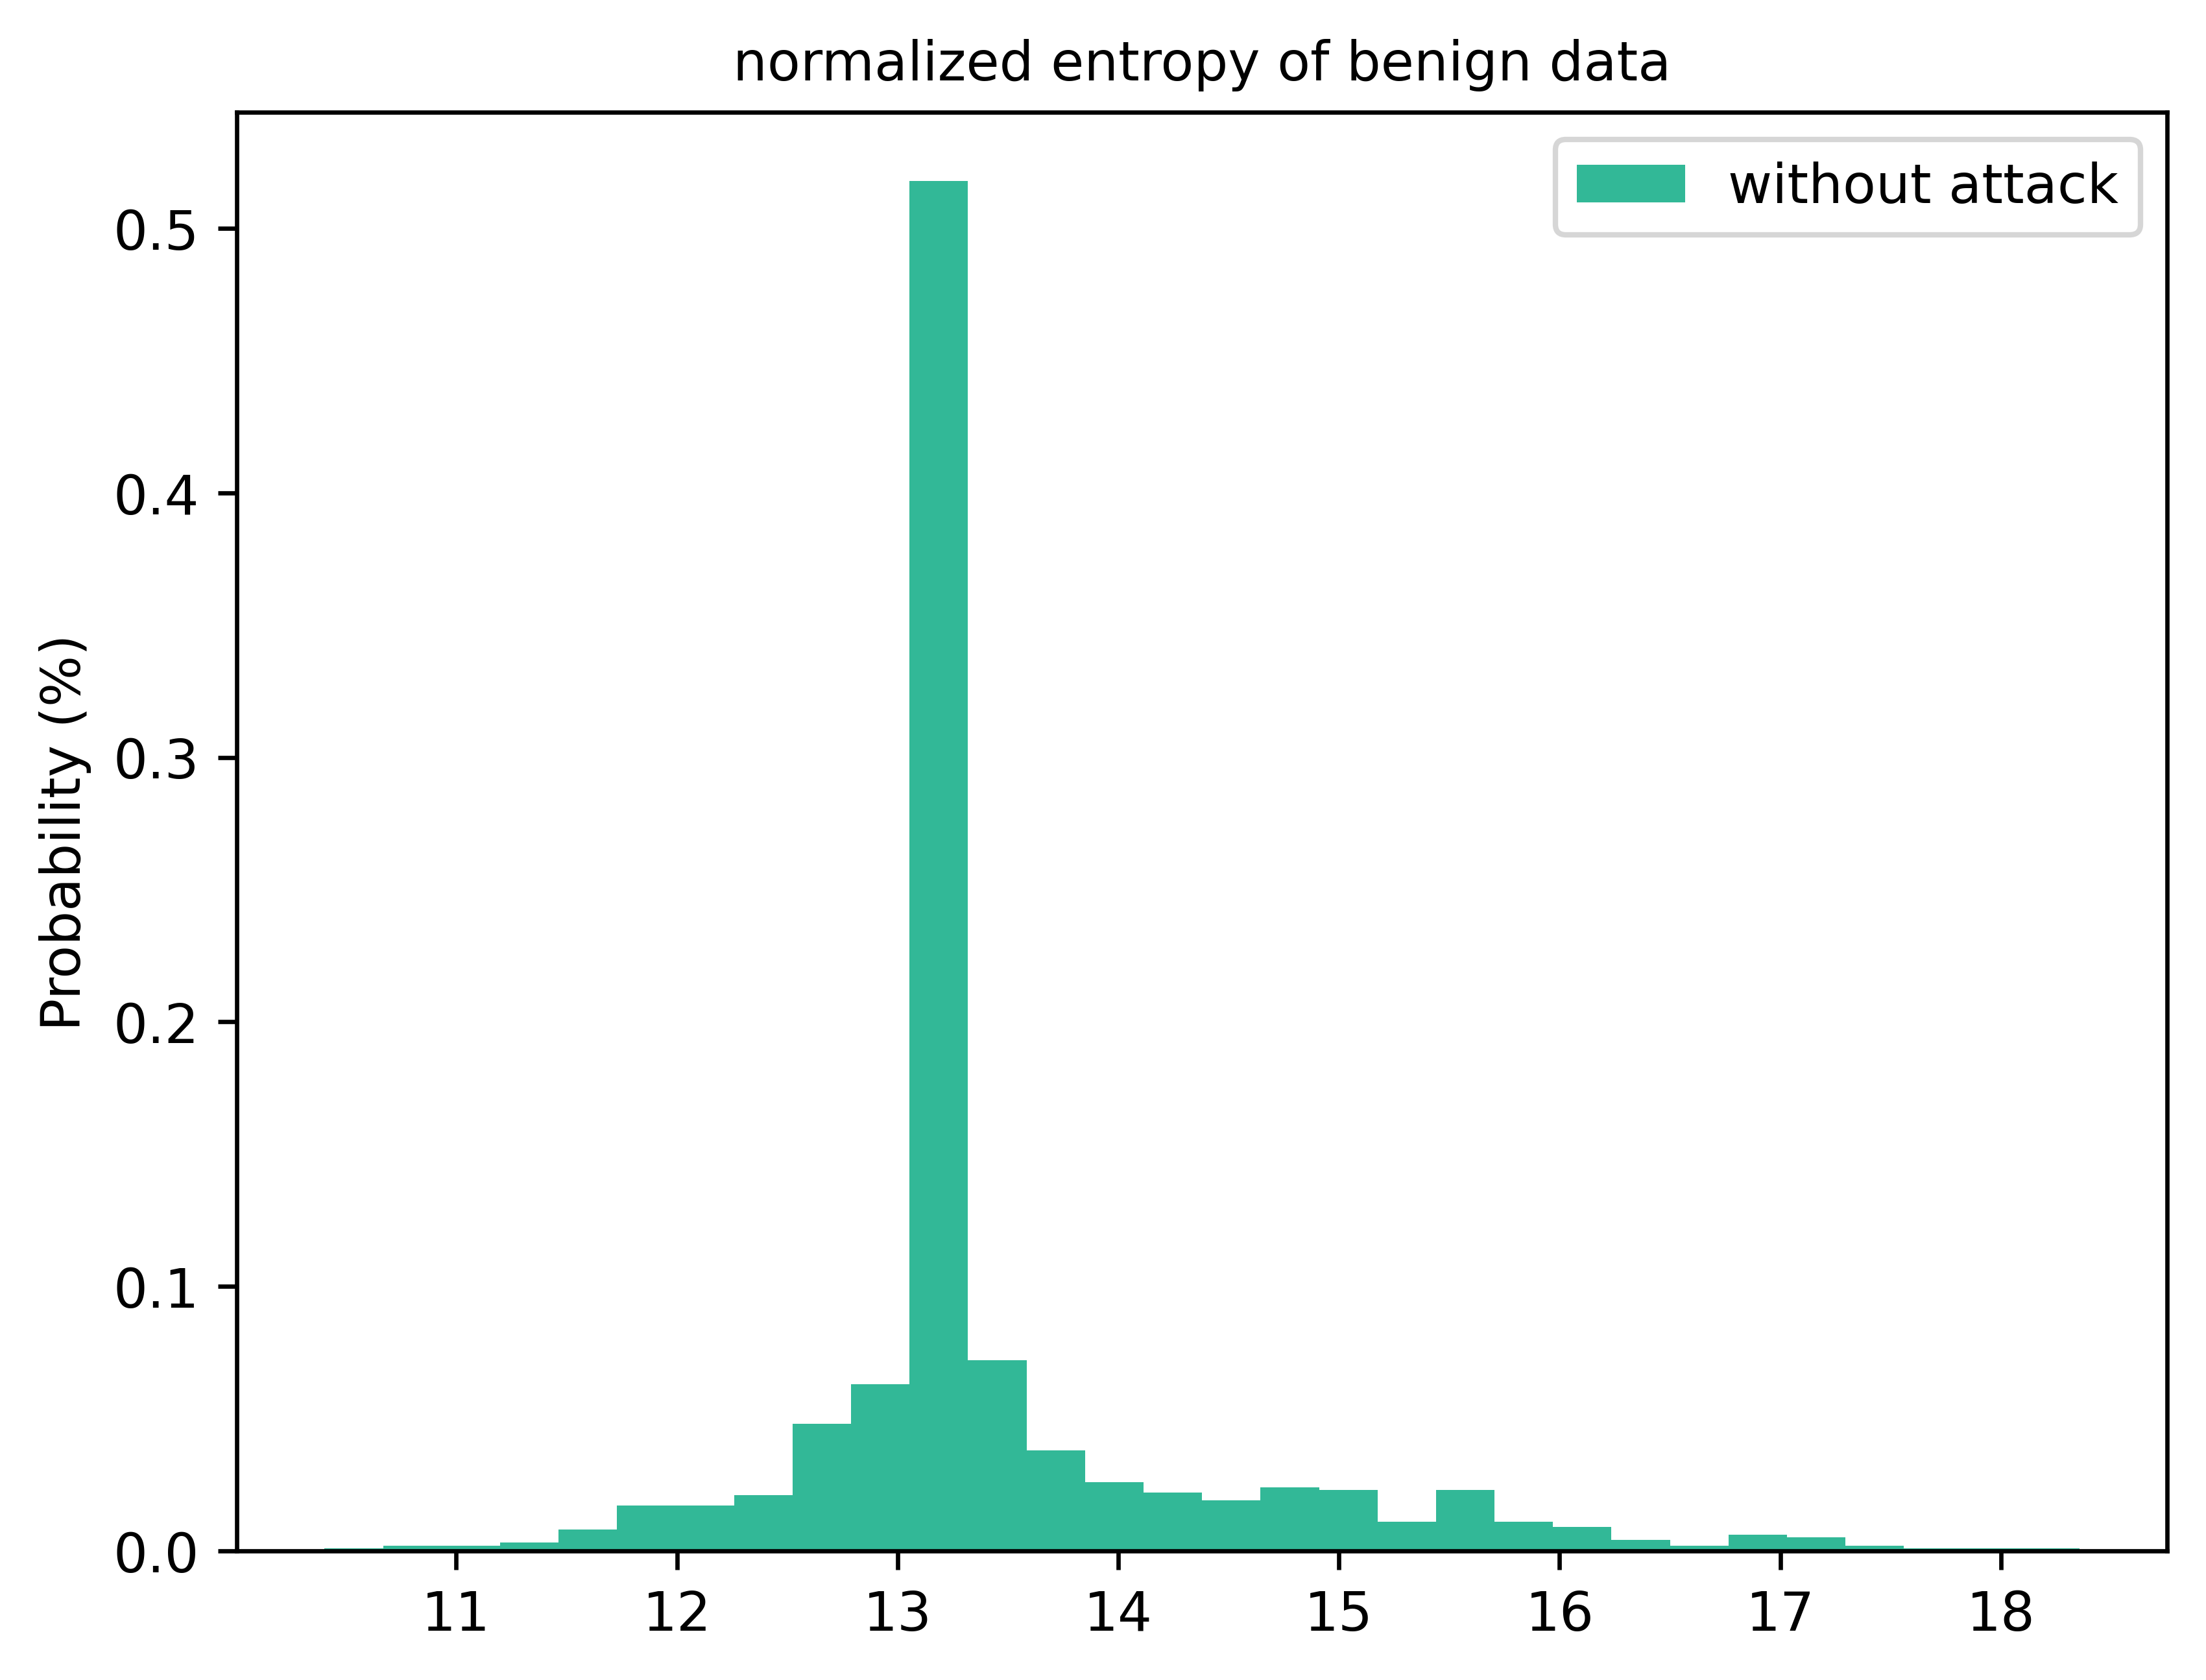

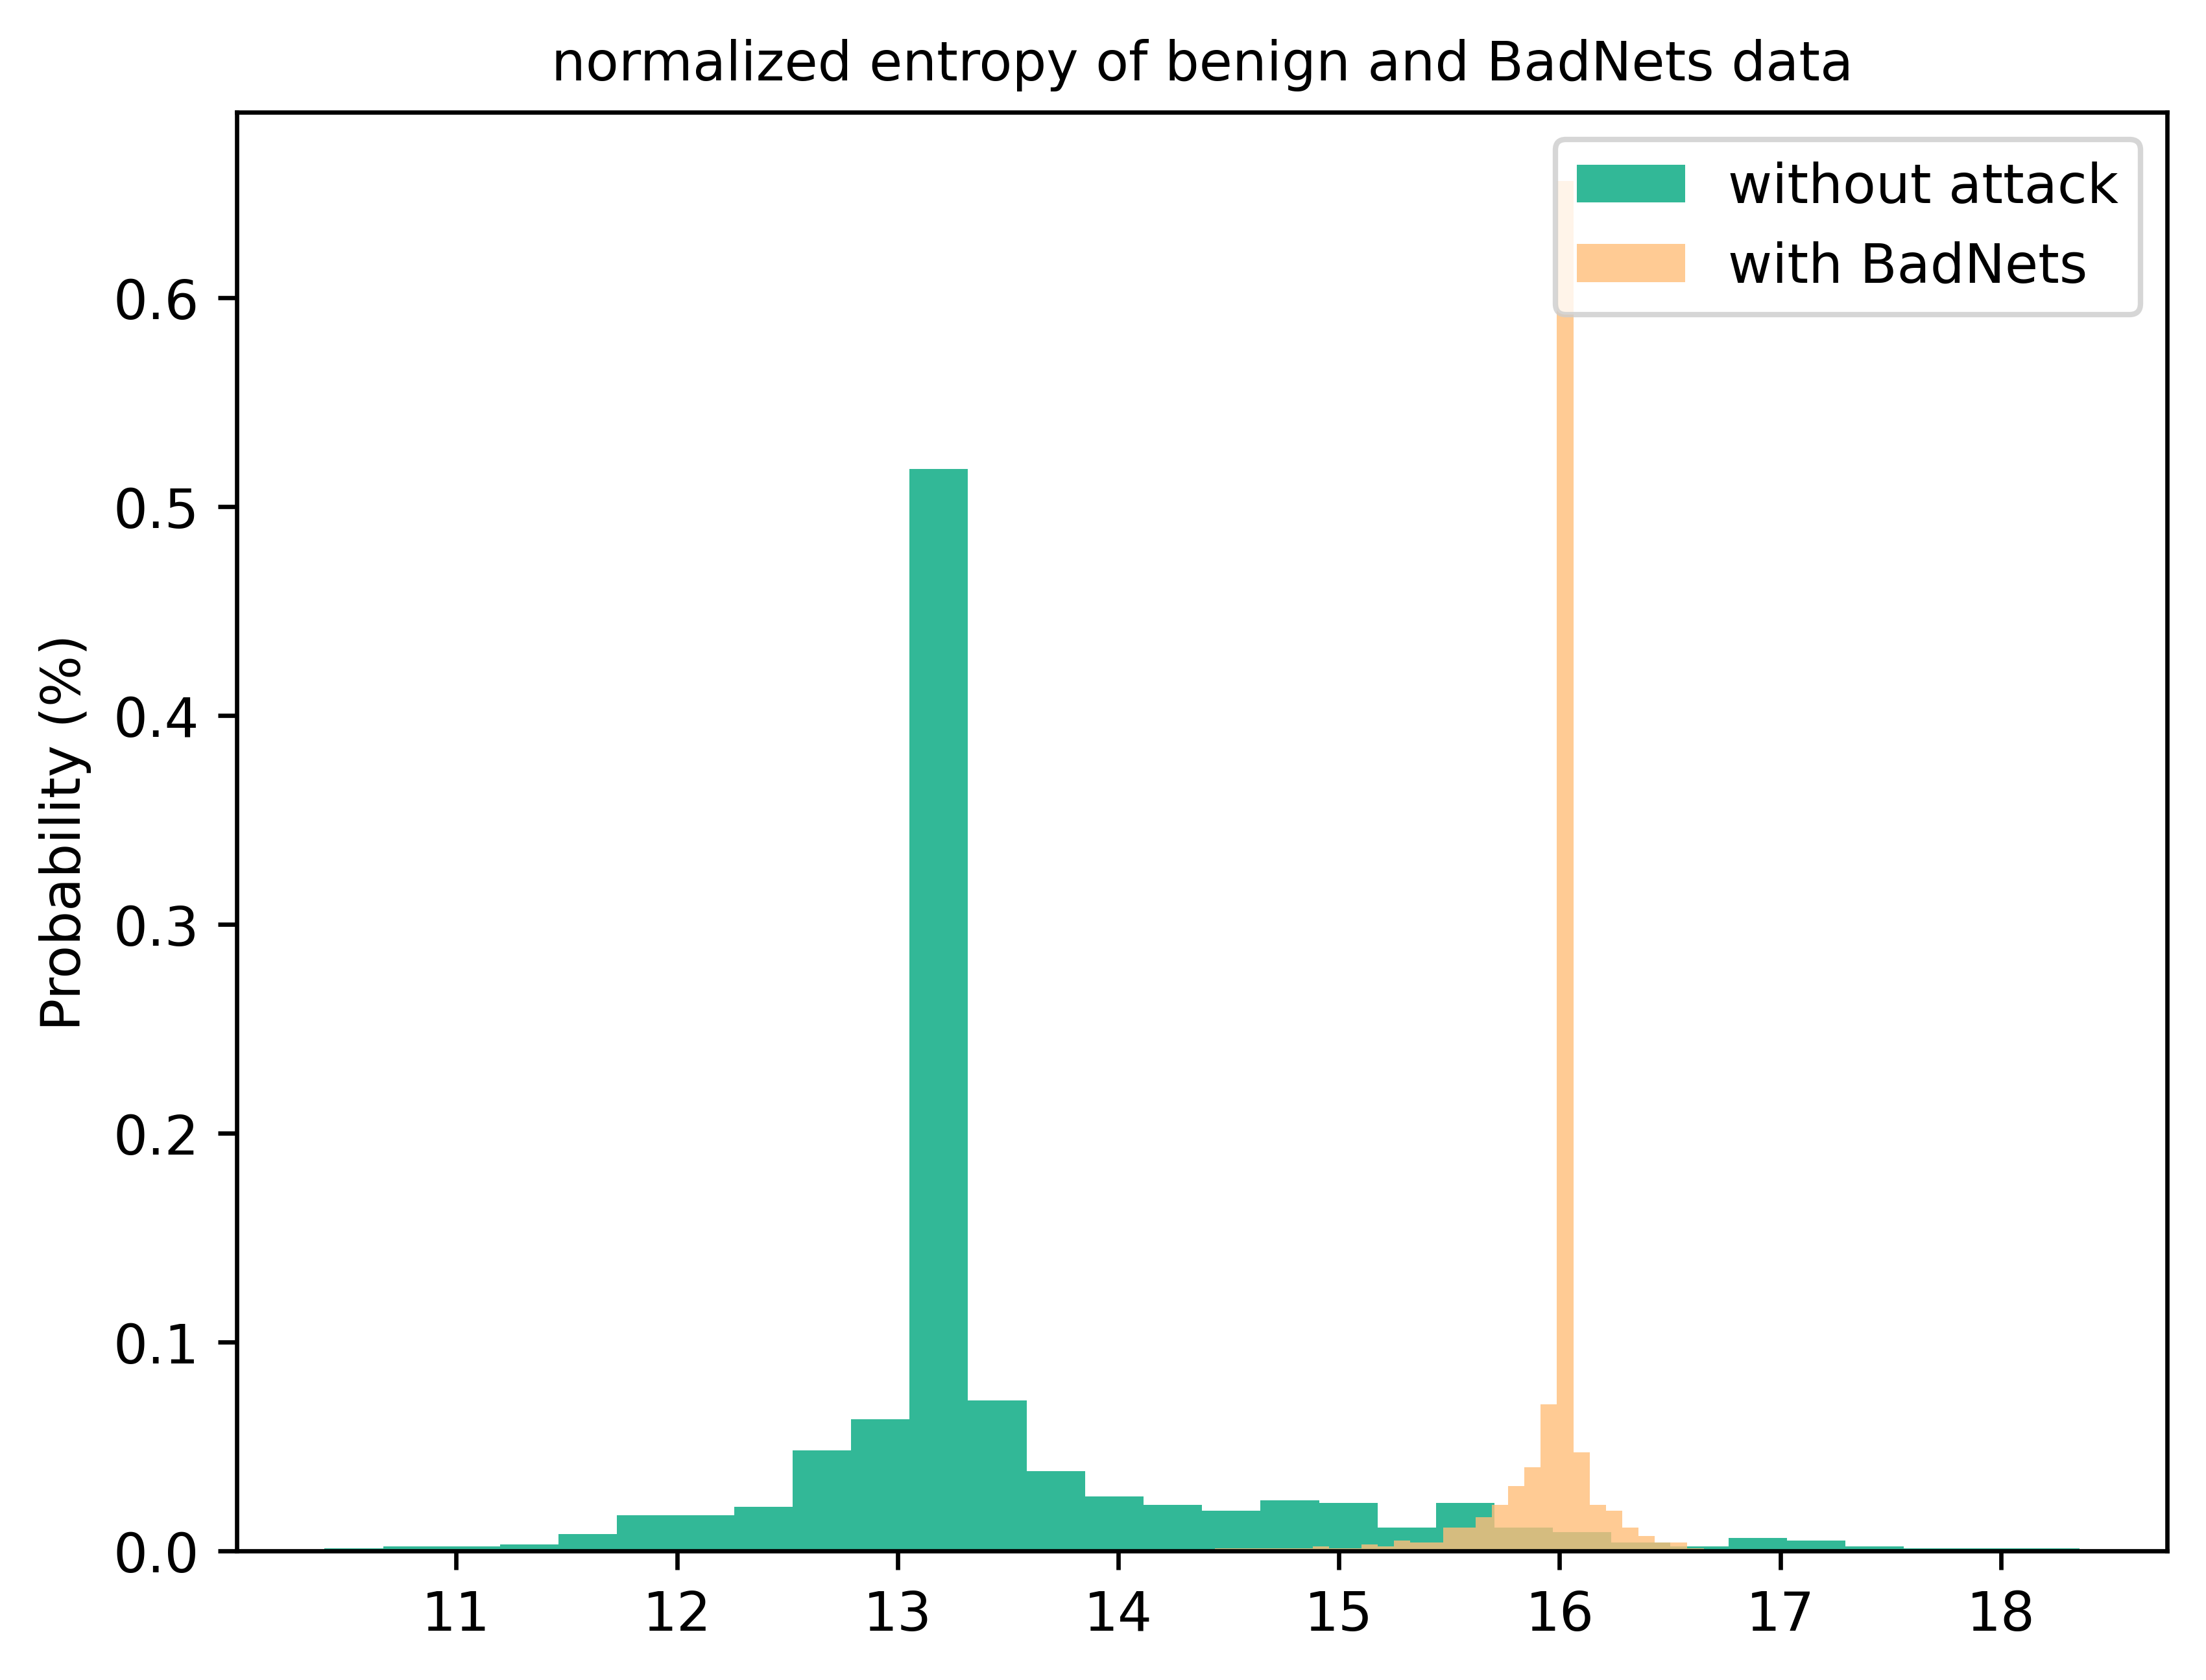

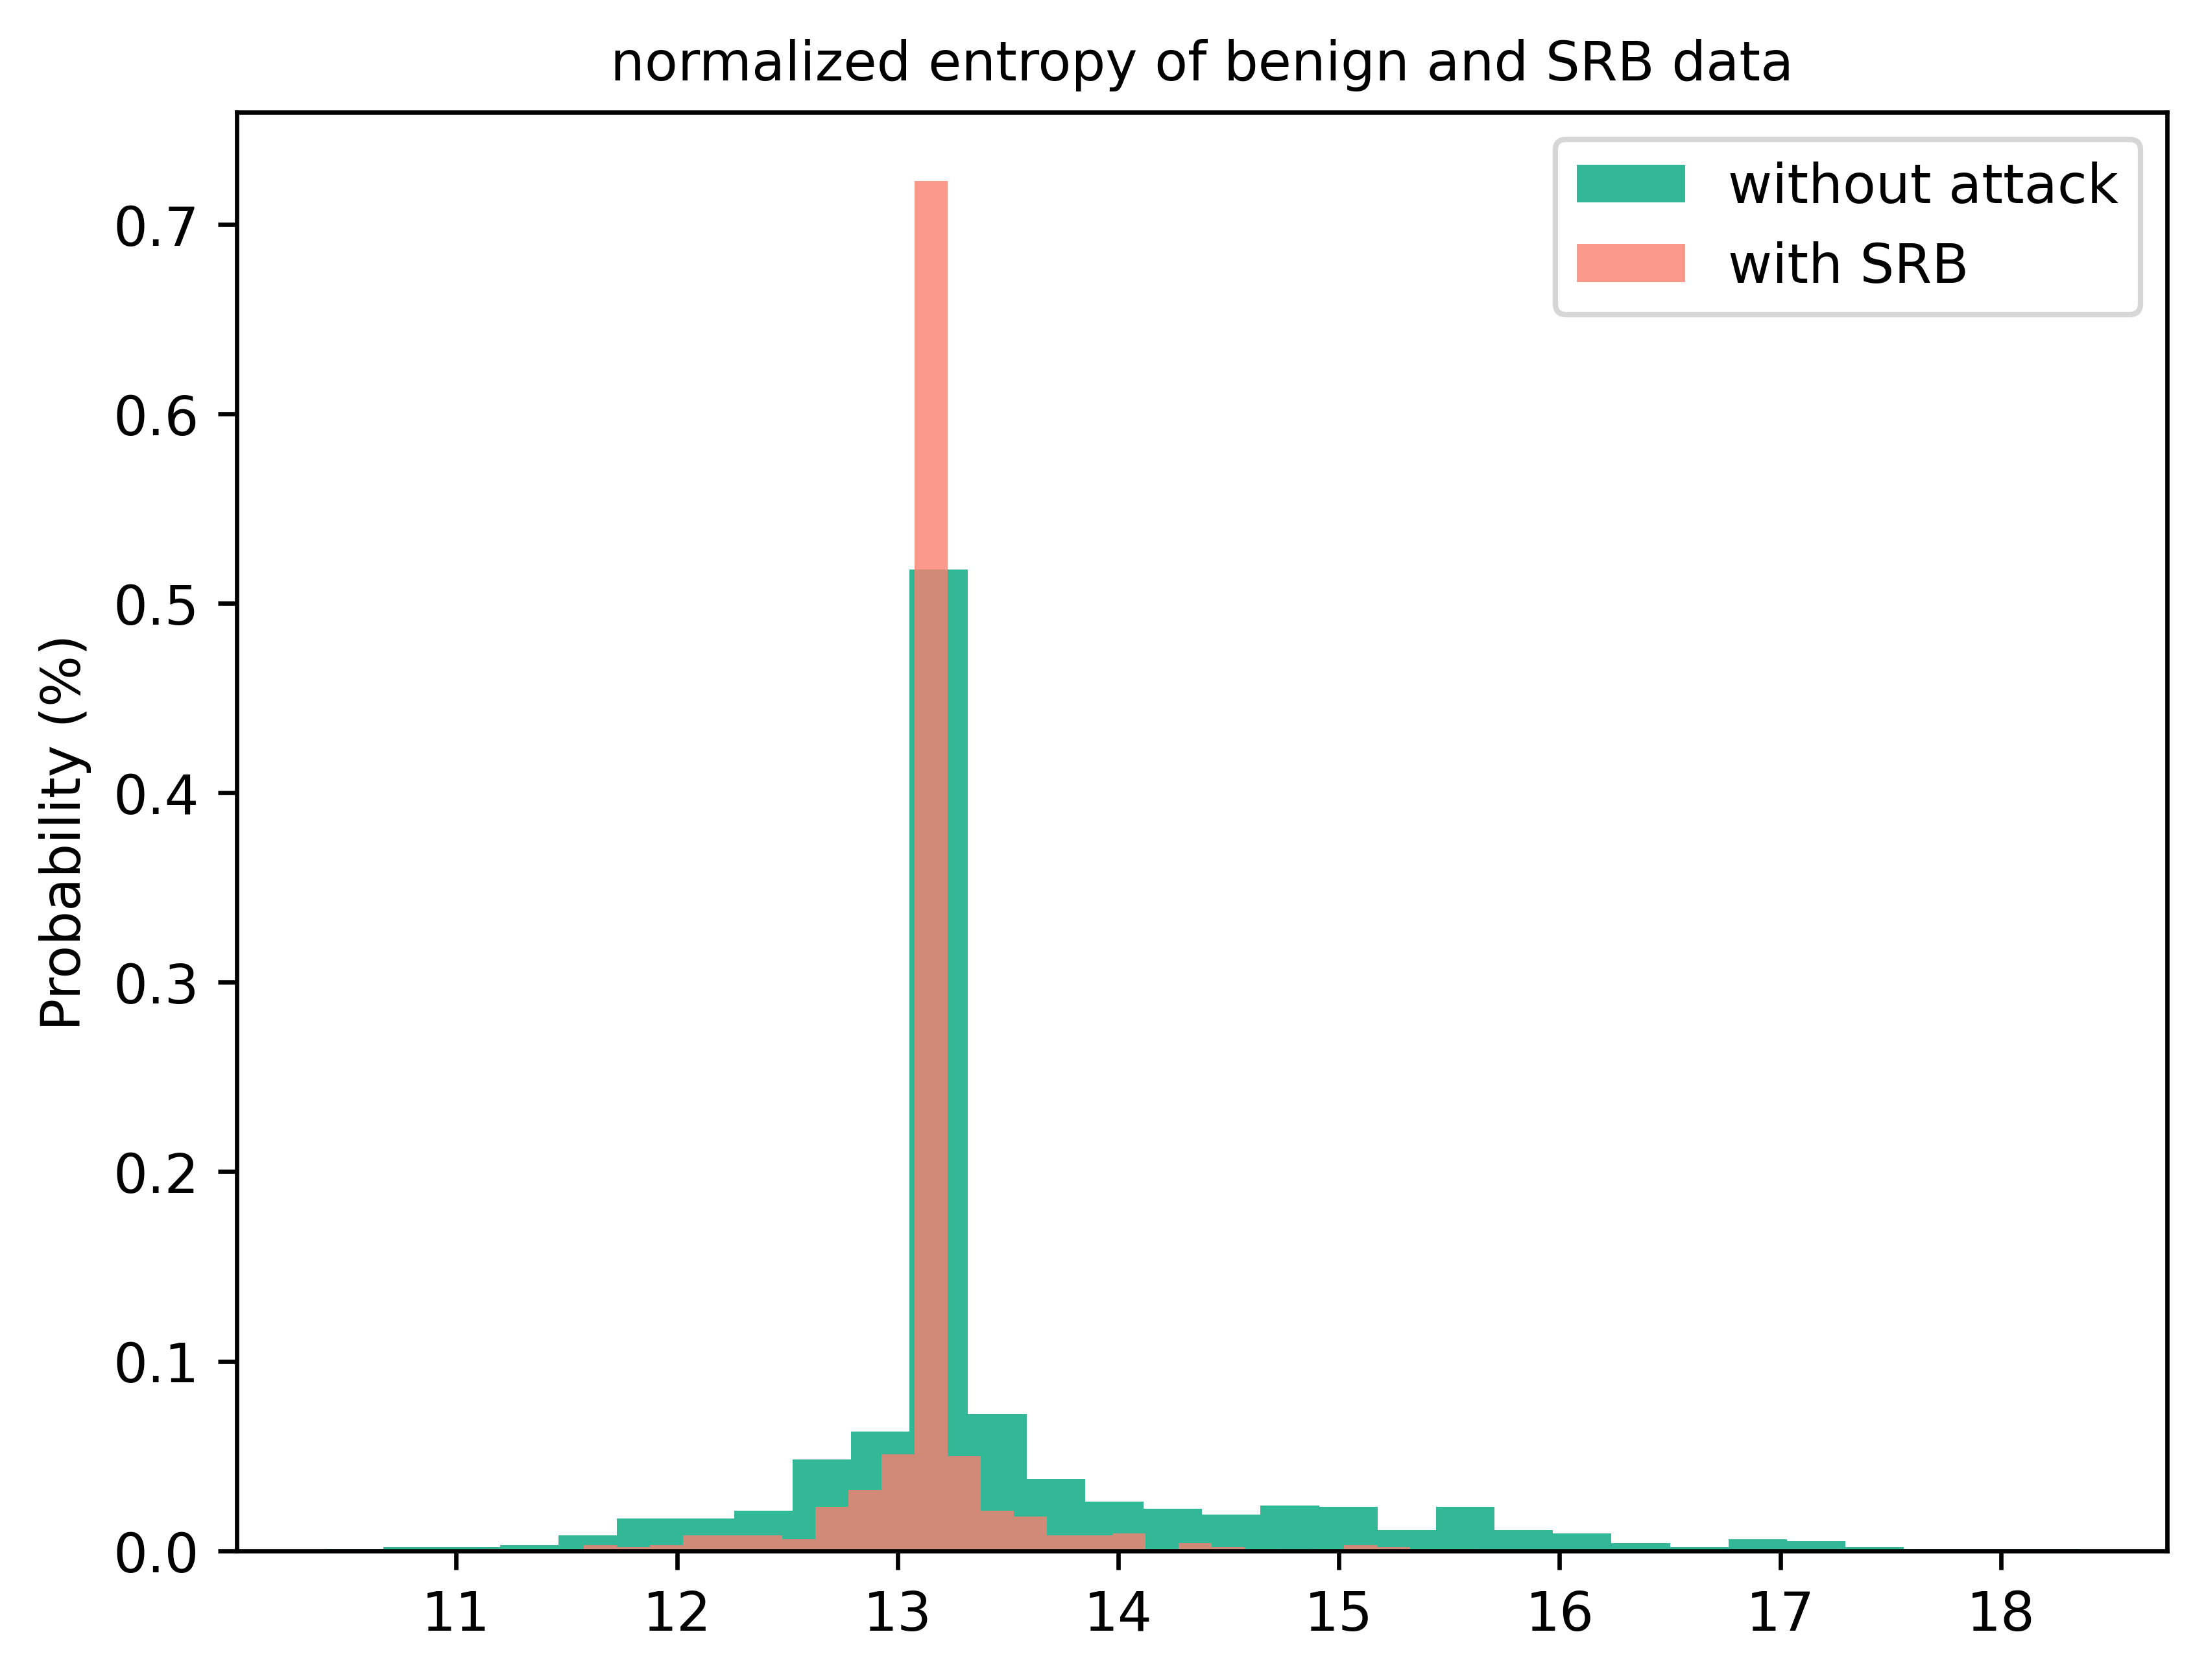

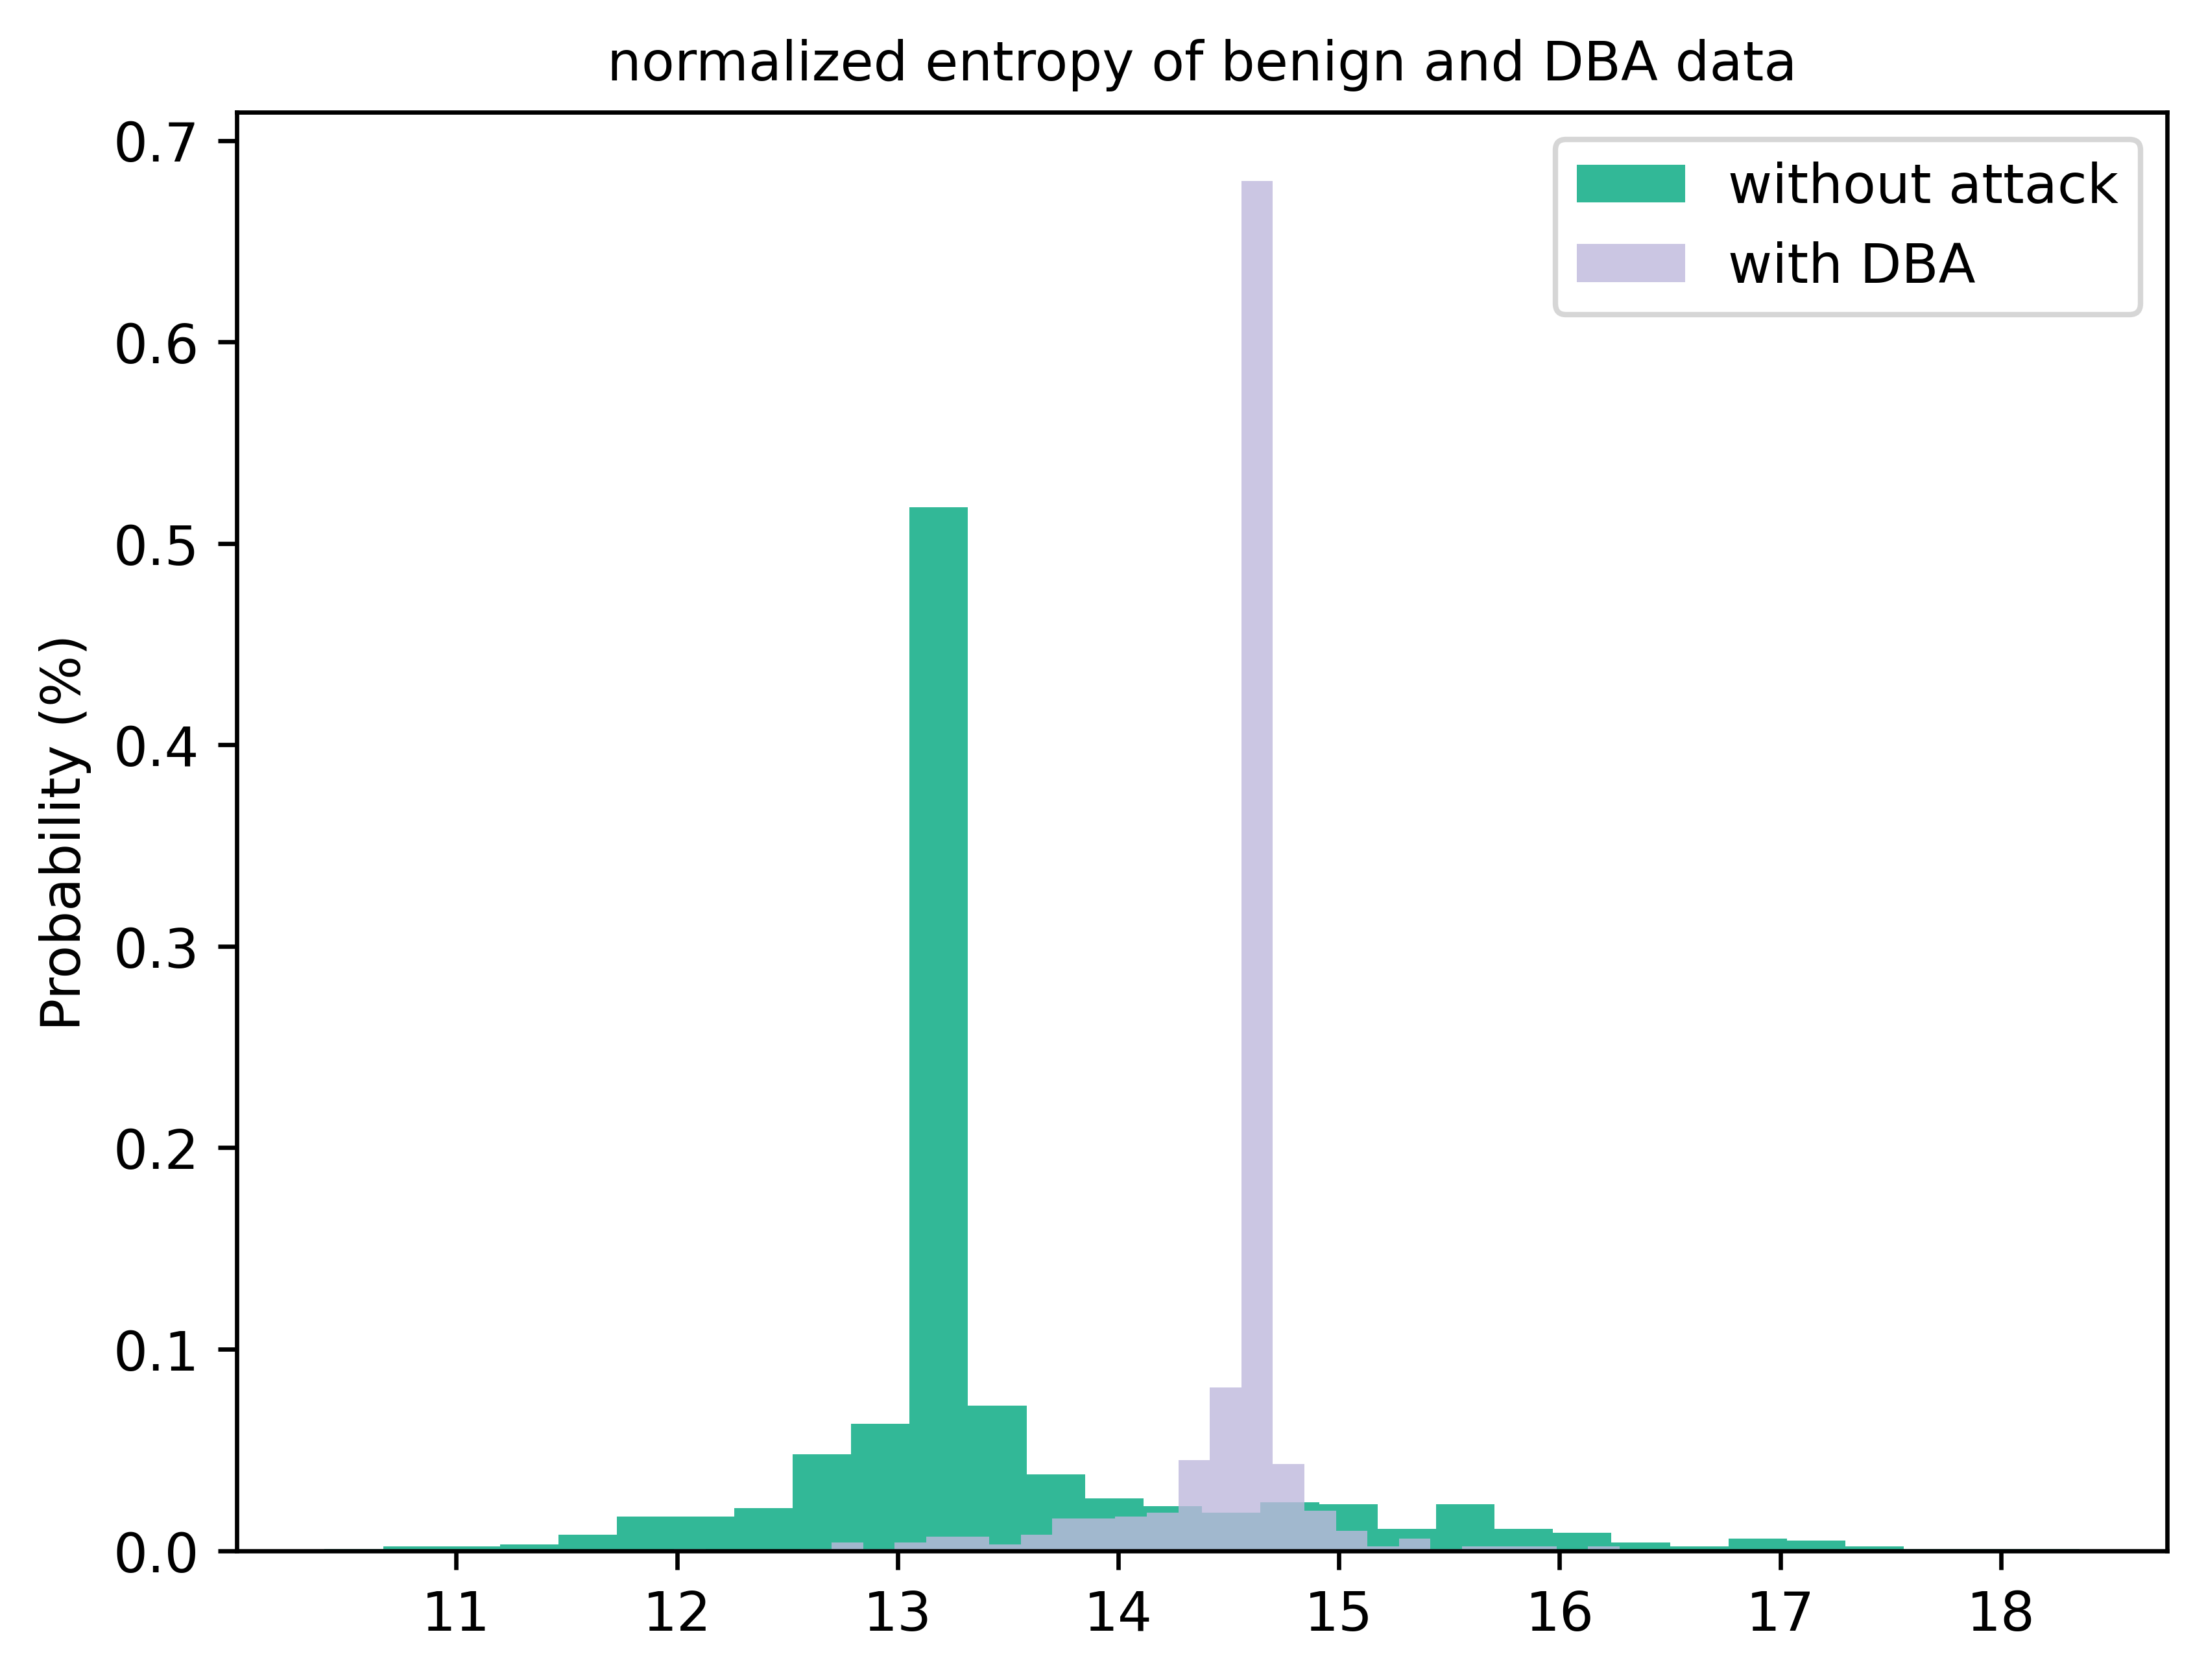

In [9]:
bins = 30
dpi = 600
alpha_b = 1
alpha = 0.8
color_benign = '#32B897'
color_patch = '#FFBE7A'
color_poison = '#FA7F6F'
color_DBA = '#BEB8DC'


plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("F:\exp_org_pic\cifar100-STRIP/DBA-benign.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack, bins, weights=np.ones(len(EntropySum_attack)) / len(EntropySum_attack), color = color_patch, alpha=alpha, label='with BadNets')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and BadNets data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("F:\exp_org_pic\cifar100-STRIP/DBA-benign2BadNets.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack_poison, bins, weights=np.ones(len(EntropySum_attack_poison)) / len(EntropySum_attack_poison), color = color_poison, alpha=alpha, label='with SRB')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and SRB data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("F:\exp_org_pic\cifar100-STRIP//DBA-benign2SRB.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack_DBA, bins, weights=np.ones(len(EntropySum_attack_DBA)) / len(EntropySum_attack_DBA), color = color_DBA, alpha=alpha, label='with DBA')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and DBA data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("F:\exp_org_pic\cifar100-STRIP//DBA-benign2DBA.tiff")
png1.close()
plt.show()

# org && org+trigger 的熵 对比，poison差别不大，patch趋势差别很大，
# no attack 和 poison 和 patch在benign数据下的熵的对比